In [ ]:
pip install -r requirements.txt --user

# Imports

In [2]:
import helperfunctions as hf
from pycaret.classification import *

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from IPython.display import clear_output
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sktime.transformations.panel.padder import PaddingTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GroupKFold
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sktime.classification.compose import ColumnEnsembleClassifier
from sktime.utils.mlflow_sktime import save_model

To generate pip requirements.txt:

`pip list --format=freeze > requirements.txt`

# Set up directories
```
-- Directory Structure --

├── Main
│   ├── Code
│   │   ├── Submission.ipynb
│   │   ├── helperfunction.py
│   ├── dataPackage
│   │   ├── task-ils
│   │   ├── task-rest
│   │   ├── EvalSet_StartEndTimes.csv
│   ├── dataPackageEval
│   │   ├── EvalSet_StartEndTimes.csv
```

In [3]:
# set directories
cwd = os.getcwd()
main_dir = os.path.split(cwd)[0]
data_pkg_trg_dir = os.path.join(main_dir, 'dataPackage')
data_ils_trg_dir = os.path.join(main_dir, 'dataPackage', 'task-ils')
# data_rest_trg_dir = os.path.join(main_dir, 'dataPackage', 'task-rest')

data_pkg_eval_dir = os.path.join(main_dir, 'dataPackageEval', 'dataPackage_eval_withOcuevts_230203')
data_ils_eval_dir = os.path.join(main_dir, 'dataPackageEval', 'dataPackage_eval_withOcuevts_230203', 'task-ils')
# data_rest_trg_dir = os.path.join(main_dir, 'dataPackageEval', 'dataPackage_eval_withOcuevts_230203', 'task-rest')

In [4]:
# create directory if not exist
output_trg_dir = os.path.join(main_dir,'Cleaned Trg Data')
if not os.path.isdir(output_trg_dir):
    os.makedirs(output_trg_dir)

output_eval_dir = os.path.join(main_dir,'Cleaned Eval Data')
if not os.path.isdir(output_eval_dir):
    os.makedirs(output_eval_dir)

# rest data cleaning (did not use rest data)
# rest_output_dir = os.path.join(main_dir,'Cleaned Data Rest')
# if not os.path.isdir(rest_output_dir):
#     os.makedirs(rest_output_dir)

ML_final_output_dir = os.path.join(main_dir,'Data Ready for ML_final')
if not os.path.isdir(ML_final_output_dir):
    os.makedirs(ML_final_output_dir)

ML_validation_output_dir = os.path.join(main_dir,'Data Ready for ML_validation')
if not os.path.isdir(ML_validation_output_dir):
    os.makedirs(ML_validation_output_dir)

model_dir = os.path.join(main_dir,'Trained Models')
if not os.path.isdir(model_dir):
    os.makedirs(model_dir)

processed_eval_dir = os.path.join(main_dir,'Data Ready for ML_eval')
if not os.path.isdir(processed_eval_dir):
    os.makedirs(processed_eval_dir)

ensembled_dir = os.path.join(main_dir,'Data Ensembled')
if not os.path.isdir(ensembled_dir):
    os.makedirs(ensembled_dir)

# Data Cleaning

## Data Cleaning for Training Set

### Subject list, level list, downsampling rates for selected sensors for training dataset

In [4]:
# Generate 'cap_name_list', 'level_list', 'sensor_freq_list'
cap_name_list = []
for cp in os.listdir(data_ils_trg_dir):
    if 'cp' in cp:
        cap_name_list.append(cp[-5:])

cap_name_list = pd.DataFrame(data=cap_name_list, columns=['cp_ID'])
cap_name_list.to_csv(os.path.join(data_pkg_trg_dir,'cap_name_list.csv'), index=False)

level_list = {'level': ['01B','02B','03B','04B']}
level_list = pd.DataFrame(level_list)
level_list.to_csv(os.path.join(data_pkg_trg_dir,'level_list.csv'), index=False)

sensor_cutoff_freq_list = {
    'sensor_name': ['lslshimmertorsoacc','lslshimmereda','lslshimmeremg','lslshimmerresp','lslrespitrace','lslshimmerecg'] ,
    'freq': [10,30,5,30,30,30]
    }
sensor_cutoff_freq_list = pd.DataFrame(sensor_cutoff_freq_list)
sensor_cutoff_freq_list.to_csv(os.path.join(data_pkg_trg_dir,'selected_sensor_cutoff_freq.csv'), index=False)

In [5]:
cap_name_list = pd.read_csv(os.path.join(data_pkg_trg_dir,'cap_name_list.csv'))
level_list = pd.read_csv(os.path.join(data_pkg_trg_dir,'level_list.csv'))
sensor_freq_list = pd.read_csv(os.path.join(data_pkg_trg_dir,'selected_sensor_cutoff_freq.csv'))

### Cleaning for selected sensors
`['lslshimmertorsoacc','lslshimmereda','lslshimmeremg','lslshimmerresp','lslrespitrace','lslshimmerecg']`

In [21]:
# data cleaning for ils trg data - output as 1 file per csv
# failed files are printed as output
for cap in cap_name_list['cp_ID']:
    for level in level_list['level']:
        for sensor in sensor_freq_list['sensor_name']:
            try:
                data_csv_list = hf.get_dirs_to_csv(data_ils_trg_dir, cap, level, sensor)
                for csv_dir in data_csv_list:
                    # get run info from filename: run, date
                    fname = os.path.split(csv_dir)[1]
                    run = fname.split('_')[6][-2:]
                    date = fname.split('_')[1][-8:]
                    # read file
                    sr = hf.get_csv_freq(csv_dir)
                    cut_off_freq = sensor_freq_list.loc[sensor_freq_list['sensor_name'] == sensor, 'freq'].iloc[0]
                    dsr = np.rint(sr/(cut_off_freq*2))
                    df = pd.read_csv(csv_dir)
                    # remove from df before simulation start and after simulation ends
                    head, tail = hf.get_head_tail_time_to_remove(csv_dir)
                    # remove before start
                    if head > 0:
                        head_rows = head * sr
                        head_rows = int(head_rows) + (head_rows % 1 > 0)
                        df = df.drop(df.index[:head_rows])
                    #remove after stop
                    if tail > 0:
                        tail_rows = tail * sr
                        tail_rows = int(tail_rows) + (tail_rows % 1 > 0)
                        df = df.drop(df.index[-tail_rows:])
                    # FFT
                    df_out = pd.DataFrame()
                    cols, times = [], []
                    for column in df:
                        if column != 'time_dn':
                            cols.append(column)
                            df1 = df[column]
                            X = np.fft.fft(df1,axis=0)
                            X_lpf = X
                            X_lpf[cut_off_freq*sr:] = 0
                            Y_lpf = np.fft.ifft(X_lpf,axis=0)
                            Y_lpf = Y_lpf.real
                            Y_dsp = Y_lpf[::int(dsr)]
                            df_out = pd.concat([df_out, pd.DataFrame(Y_dsp)], axis=1)
                            
                    df_out.columns = cols
                    # add time column
                    for i in range(df_out.shape[0]):
                        times.append(i*1/(cut_off_freq*2))
                    df_out.insert(0, 'Time', times)
                    output_csv = os.path.join(output_trg_dir, f"{sensor}_{level}_{cap}_{date}_{run}.csv")
                    df_out.to_csv(output_csv, index=False)
            except:
                print (cap, level, sensor, run)
                pass

cp009 01B lslshimmereda 01
cp009 01B lslshimmerresp 01
cp009 01B lslshimmerecg 01
cp009 02B lslshimmereda 03
cp009 02B lslshimmerresp 03
cp009 02B lslshimmerecg 03
cp009 03B lslshimmereda 02
cp009 03B lslshimmerresp 02
cp009 03B lslshimmerecg 02
cp009 04B lslshimmereda 04
cp009 04B lslshimmerresp 04
cp009 04B lslshimmerecg 04
cp028 01B lslshimmeremg 12


### Move HTC Vive Eye Data to clean data folder

In [26]:
# Removes head and tail of data where simulation is paused
# Test data only
# Failed files are printed as output

sensor = 'lslhtcviveeye'
feature_list = ['gaze_origin_l','gaze_direction_l','pupil_diameter_l','eye_openness_l','pupil_position_l']

for cap in cap_name_list['cp_ID']:
    for level in level_list['level']:
        try:
            data_csv_list = hf.get_dirs_to_csv(data_ils_trg_dir, cap, level, sensor)
            for csv_dir in data_csv_list:
                # get run info from filename: run, date
                fname = os.path.split(csv_dir)[1]
                run = fname.split('_')[6][-2:]
                date = fname.split('_')[1][-8:]
                # read file
                sr = hf.get_csv_freq(csv_dir)
                df = pd.read_csv(csv_dir)
                # remove from df before simulation start and after simulation ends
                head, tail = hf.get_head_tail_time_to_remove(csv_dir)
                # remove before start
                if head > 0:
                    head_rows = head * sr
                    head_rows = int(head_rows) + (head_rows % 1 > 0)
                    df = df.drop(df.index[:head_rows])
                # remove after stop
                if tail > 0:
                    tail_rows = tail * sr
                    tail_rows = int(tail_rows) + (tail_rows % 1 > 0)
                    df = df.drop(df.index[-tail_rows:])
                # generate csv files per feature
                for feature in feature_list:
                    df_out = df.filter(like=feature)
                    output_csv = os.path.join(output_trg_dir, f"{sensor}_{feature}_{level}_{cap}_{date}_{run}.csv")
                    # print(df_out)
                    df_out.to_csv(output_csv, index=False)
        except:
            print (cap, level, sensor, run)
            pass

cp003 01B lslhtcviveeye 01
cp003 02B lslhtcviveeye 03
cp003 03B lslhtcviveeye 02
cp003 04B lslhtcviveeye 04
cp027 01B lslhtcviveeye 01
cp027 03B lslhtcviveeye 02


## Data Cleaning for Eval Set

### Subject list for eval dataset

In [39]:
# Generate 'cap_name_list', 'level_list', 'sensor_freq_list'
cap_name_eval_list = []
for cp in os.listdir(data_ils_eval_dir):
    if 'cp' in cp:
        cap_name_eval_list.append(cp[-5:])

cap_name_eval_list = pd.DataFrame(data=cap_name_eval_list, columns=['cp_ID'])
cap_name_eval_list.to_csv(os.path.join(data_pkg_eval_dir,'cap_name_list.csv'), index=False)

In [6]:
cap_name_eval_list = pd.read_csv(os.path.join(data_pkg_eval_dir,'cap_name_list.csv'))
sensor_freq_list = pd.read_csv(os.path.join(data_pkg_trg_dir,'selected_sensor_cutoff_freq.csv'))

### Load eval data set start times

In [7]:
start_times_file = os.path.join(main_dir, 'dataPackageEval', 'EvalSet_StartEndTimes.csv')
start_times = pd.read_csv(start_times_file)

### Cleaning for selected sensors
`['lslshimmertorsoacc','lslshimmereda','lslshimmeremg','lslshimmerresp','lslrespitrace','lslshimmerecg']`

In [35]:
# data cleaning for ils eval data - output as 1 file per csv
# failed files are printed as output
level = None
for cap in cap_name_eval_list['cp_ID']:
    for sensor in sensor_freq_list['sensor_name']:
        try:
            data_csv_list = hf.get_dirs_to_csv(data_ils_eval_dir, cap, level, sensor)
            for csv_dir in data_csv_list:
                # get run info from filename: run, date
                fname = os.path.split(csv_dir)[1]
                run = fname.split('_')[5][-2:]
                date = fname.split('_')[1][-8:]
                
                # read file
                sr = hf.get_csv_freq(csv_dir)
                cut_off_freq = sensor_freq_list.loc[sensor_freq_list['sensor_name'] == sensor, 'freq'].iloc[0]
                dsr = np.rint(sr/(cut_off_freq*2))
                df = pd.read_csv(csv_dir)
                
                # remove from df before simulation start and after it ends
                fname = csv_dir.split('\\')[-1]
                subj = fname.split('_')[0]
                run_num = fname.split('_')[5][-3:]
                start_time = start_times.loc[(start_times['Subject'].str.contains(subj)) & (start_times['Run'] == int(run_num))]['StartTime'].values[0]
                end_time = start_times.loc[(start_times['Subject'].str.contains(subj)) & (start_times['Run'] == int(run_num))]['EndTime'].values[0]
                df = df.loc[(df['time_dn'] > start_time) & (df['time_dn'] < end_time)]
                    
                df_out = pd.DataFrame()
                cols, times = [], []
                for column in df:
                    if column != 'time_dn':
                        cols.append(column)
                        df1 = df[column]
                        X = np.fft.fft(df1,axis=0)
                        X_lpf = X
                        X_lpf[cut_off_freq*sr:] = 0
                        Y_lpf = np.fft.ifft(X_lpf,axis=0)
                        Y_lpf = Y_lpf.real
                        Y_dsp = Y_lpf[::int(dsr)]
                        df_out = pd.concat([df_out, pd.DataFrame(Y_dsp)], axis=1)
                        
                df_out.columns = cols
                # add time column
                for i in range(df_out.shape[0]):
                    times.append(i*1/(cut_off_freq*2))
                df_out.insert(0, 'Time', times)
                output_csv = os.path.join(output_eval_dir, f"{sensor}_{cap}_{date}_{run}.csv")
                df_out.to_csv(output_csv, index=False)
        except:
            print (cap, sensor, run)
            pass

### Move HTC Vive Eye Data to clean data folder

In [39]:
# Removes head of data where simulation is paused
# Test data only
# Failed files are printed as output

sensor = 'lslhtcviveeye'
feature_list = ['gaze_origin_l','gaze_direction_l','pupil_diameter_l','eye_openness_l','pupil_position_l']
level = None

for cap in cap_name_eval_list['cp_ID']:
    try:
        data_csv_list = hf.get_dirs_to_csv(data_ils_eval_dir, cap, level, sensor)
        for csv_dir in data_csv_list:
            # get run info from filename: run, date
            fname = os.path.split(csv_dir)[1]
            run = fname.split('_')[5][-2:]
            date = fname.split('_')[1][-8:]

            # read file
            df = pd.read_csv(csv_dir)

            # remove from df before simulation start and after it ends
            fname = os.path.split(csv_dir)[1]
            # fname = csv_dir.split('\\')[-1]
            subj = fname.split('_')[0]
            run_num = fname.split('_')[5][-3:]
            start_time = start_times.loc[(start_times['Subject'].str.contains(subj)) & (start_times['Run'] == int(run_num))]['StartTime'].values[0]
            end_time = start_times.loc[(start_times['Subject'].str.contains(subj)) & (start_times['Run'] == int(run_num))]['EndTime'].values[0]
            df = df.loc[(df['time_dn'] > start_time) & (df['time_dn'] < end_time)]
            # generate csv files per feature
            for feature in feature_list:
                df_out = df.filter(like=feature)
                output_csv = os.path.join(output_eval_dir, f"{sensor}_{feature}_{cap}_{date}_{run}.csv")
                df_out.to_csv(output_csv, index=False)
            
    except:
        print (cap, sensor, run)
        pass

## Generate 5 folds for train test split

In [8]:
data_dir = output_trg_dir
target_dir = os.path.join(main_dir, 'Data Ready for ML_folds')

# Get list of subjects
data_files = hf.get_all_data_csv_filenames(data_dir)
split_files = [i.split('_') for i in data_files]
subjects = [i[-3] for i in split_files]
subjects = list(set(subjects))
subjects.sort()

# Split
train, test = [], []

grpkfold = GroupKFold(n_splits=5)
for train_i, test_i in grpkfold.split(X=subjects, groups=subjects):
    train.append(train_i)
    test.append(test_i)

train_splits, test_splits = {}, {}

for i, fold in enumerate(train):
    train_splits[i] = []
    for j in fold:
        train_splits[i].append(subjects[j])

for i, fold in enumerate(test):
    test_splits[i] = []
    for j in fold:
        test_splits[i].append(subjects[j])

In [9]:
# Check splits
for i in range(5):
    print(train_splits[i])
    print()
    print(test_splits[i])
    print(len(train_splits[i]) + len(test_splits[i]))
    print()

['cp003', 'cp005', 'cp006', 'cp008', 'cp009', 'cp012', 'cp013', 'cp014', 'cp015', 'cp017', 'cp018', 'cp019', 'cp020', 'cp022', 'cp023', 'cp024', 'cp025', 'cp026', 'cp027', 'cp029', 'cp030', 'cp031', 'cp032', 'cp035', 'cp036', 'cp037', 'cp038', 'cp042']

['cp004', 'cp011', 'cp016', 'cp028', 'cp033', 'cp039', 'cp043']
35

['cp003', 'cp004', 'cp005', 'cp006', 'cp008', 'cp011', 'cp012', 'cp014', 'cp016', 'cp017', 'cp018', 'cp019', 'cp022', 'cp023', 'cp024', 'cp025', 'cp026', 'cp028', 'cp029', 'cp030', 'cp032', 'cp033', 'cp035', 'cp036', 'cp037', 'cp039', 'cp042', 'cp043']

['cp009', 'cp013', 'cp015', 'cp020', 'cp027', 'cp031', 'cp038']
35

['cp003', 'cp004', 'cp005', 'cp006', 'cp009', 'cp011', 'cp012', 'cp013', 'cp015', 'cp016', 'cp017', 'cp018', 'cp020', 'cp022', 'cp025', 'cp027', 'cp028', 'cp029', 'cp030', 'cp031', 'cp032', 'cp033', 'cp035', 'cp036', 'cp038', 'cp039', 'cp042', 'cp043']

['cp008', 'cp014', 'cp019', 'cp023', 'cp024', 'cp026', 'cp037']
35

['cp003', 'cp004', 'cp005', 'cp008

# Individual data types

## EMG

In [ ]:
# Did not use

## EDA

In [ ]:
# Did not use

## ECG

### Find max length of datasets across train and eval sets for padding

In [23]:
hz = 60
time_step = 1/hz
sensor = 'lslshimmerecg'

# calculating pad length should use longest of all runs for same sensor
df_runs_forpadlength_trg = hf.get_df_runs(output_trg_dir, sensor, '', '', False)
pad_length_trg = int(df_runs_forpadlength_trg['time'].max()/time_step)+2

df_runs_forpadlength_eval = hf.get_df_runs(output_eval_dir, sensor, '', '', False, True)
pad_length_eval = int(df_runs_forpadlength_eval['time'].max()/time_step)+2

pad_length = max(pad_length_trg, pad_length_eval)
pad_length

55418

### Validate model on training data folds
#### Generate folds

In [ ]:
%%time
# Generate folds of training data
data_dir = output_trg_dir
target_dir = ML_validation_output_dir
sensor = 'lslshimmerecg'
level = ''

scaler = StandardScaler()

for i in train_splits:
    file_suffix = f'train_lslshimmerecg_standard_padtransform{i}'
    subject = train_splits[i]
    hf.generate_ml_data(data_dir, target_dir, file_suffix, scaler, pad_length, sensor, subject, level)
    print()

In [8]:
%%time
# Generate folds of test data
for i in test_splits:
    file_suffix = f'test_lslshimmerecg_standard_padtransform{i}'
    subject = test_splits[i]
    hf.generate_ml_data(data_dir, target_dir, file_suffix, scaler, pad_length, sensor, subject, level)
    print()

Number of runs detected: 84
X shape: (84, 3, 55418)
y shape: (84,)
Saved files:
	X_test_lslshimmerecg_standard_padtransform0.npy
	y_test_lslshimmerecg_standard_padtransform0.npy

Number of runs detected: 72
X shape: (72, 3, 55418)
y shape: (72,)
Saved files:
	X_test_lslshimmerecg_standard_padtransform1.npy
	y_test_lslshimmerecg_standard_padtransform1.npy

Number of runs detected: 84
X shape: (84, 3, 55418)
y shape: (84,)
Saved files:
	X_test_lslshimmerecg_standard_padtransform2.npy
	y_test_lslshimmerecg_standard_padtransform2.npy

Number of runs detected: 83
X shape: (83, 3, 55418)
y shape: (83,)
Saved files:
	X_test_lslshimmerecg_standard_padtransform3.npy
	y_test_lslshimmerecg_standard_padtransform3.npy

Number of runs detected: 84
X shape: (84, 3, 55418)
y shape: (84,)
Saved files:
	X_test_lslshimmerecg_standard_padtransform4.npy
	y_test_lslshimmerecg_standard_padtransform4.npy



#### Set up model

In [24]:
from sktime.classification.interval_based import SupervisedTimeSeriesForest

def ecg_folds(n_estimators=250, n_jobs=-1, random_state=42, result_CV = None):
    data_dir = os.path.join(main_dir,'Data Ready for ML_validation')
    probabilities = {}

    for i in range(5):
        X_train = np.load(os.path.join(data_dir, f'X_train_lslshimmerecg_standard_padtransform{i}.npy'))
        y_train = np.load(os.path.join(data_dir, f'y_train_lslshimmerecg_standard_padtransform{i}.npy'))
        X_test = np.load(os.path.join(data_dir, f'X_test_lslshimmerecg_standard_padtransform{i}.npy'))
        y_test = np.load(os.path.join(data_dir, f'y_test_lslshimmerecg_standard_padtransform{i}.npy'))

        # only use first 2 columns of data on la_ra and ll_ra.
        clf = ColumnEnsembleClassifier(
            estimators=[
                ("est1", SupervisedTimeSeriesForest(n_estimators, n_jobs, random_state), [0]),
                ("est2", SupervisedTimeSeriesForest(n_estimators, n_jobs, random_state), [1])
            ]
        )

        clf.fit(X_train, y_train)
        y_pred_proba_SupervisedTimeSeriesForest = clf.predict_proba(X_test)
        probabilities[i] = y_pred_proba_SupervisedTimeSeriesForest
        # Log results
        class_list = [0,1,2,3]
        result_CV = hf.log_result(f'Set {i}', class_list, y_test, y_pred_proba_SupervisedTimeSeriesForest, result_CV)
        
        print(f'\rFold {i} complete', end='')
    print()
    return result_CV, probabilities

#### Runs

In [ ]:
%%time

result, _ = ecg_folds(100, -1, 42)
tmp = pd.DataFrame(result)
tmp.mean()

Fold 4 complete
CPU times: total: 45min 32s
Wall time: 1h 17min 50s


accuracy_score    0.361264
AUC_score         0.648099
F1_score          0.321160
dtype: float64

In [ ]:
%%time

result, _ = ecg_folds(150, -1, 42)
tmp = pd.DataFrame(result)
tmp.mean()

Fold 4 complete
CPU times: total: 47min 27s
Wall time: 1h 33min 41s


accuracy_score    0.362880
AUC_score         0.653857
F1_score          0.321408
dtype: float64

In [ ]:
%%time

result, _ = ecg_folds(200, -1, 42)
tmp = pd.DataFrame(result)
tmp.mean()

Fold 4 complete
CPU times: total: 48min 37s
Wall time: 1h 50min 57s


accuracy_score    0.372375
AUC_score         0.653808
F1_score          0.333089
dtype: float64

In [ ]:
%%time

result, _ = ecg_folds(240, -1, 42)
tmp = pd.DataFrame(result)
tmp.mean()

Fold 4 complete
CPU times: total: 49min 27s
Wall time: 2h 4min 13s


accuracy_score    0.383090
AUC_score         0.656757
F1_score          0.342569
dtype: float64

In [ ]:
%%time

result, _ = ecg_folds(250, -1, 42)
tmp = pd.DataFrame(result)
tmp.mean()

Fold 4 complete
CPU times: total: 49min 17s
Wall time: 2h 12min 56s


accuracy_score    0.390261
AUC_score         0.655580
F1_score          0.351113
dtype: float64

In [ ]:
%%time

result, _ = ecg_folds(260, -1, 42)
tmp = pd.DataFrame(result)
tmp.mean()

Fold 4 complete
CPU times: total: 50min 4s
Wall time: 2h 11min 18s


accuracy_score    0.375182
AUC_score         0.655679
F1_score          0.334513
dtype: float64

### Generate probabilities for ensemble model

In [ ]:
%%time

result, probabilities = ecg_folds(250, -1, 42)
with open(os.path.join(ensembled_dir, 'raw_ecg_probabilities.pkl'), 'wb') as f:
    pickle.dump(probabilities, f)
tmp = pd.DataFrame(result)
tmp.mean()

In [12]:
# Get run info
data_dir = output_trg_dir
sensor = 'lslshimmerecg'
level = ''

df_combined = pd.DataFrame()
split_df_list = []
for i in range(5):
    subject = test_splits[i]
    df_runs = hf.get_df_runs(data_dir, sensor, subject, level, True)
    df_runs = df_runs.drop('time', axis=1)
    df_proba = pd.DataFrame(probabilities[i])
    df_proba.columns = ['lslshimmerecg_01B', 'lslshimmerecg_02B', 'lslshimmerecg_03B', 'lslshimmerecg_04B']
    df_cur = pd.concat([df_runs, df_proba], axis=1)
    split_df_list.append(df_cur)
    df_combined = pd.concat([df_combined, df_cur], axis=0)

Number of runs detected: 71
Number of runs detected: 84
Number of runs detected: 84
Number of runs detected: 84
Number of runs detected: 84


In [13]:
# Combine probabilities with run info and save it

target_dir = os.path.join(main_dir,'Data Ensembled')

df_combined_lslshimmerecg = df_combined.copy()
df_combined_lslshimmerecg = df_combined_lslshimmerecg.sort_values(['subject','difficulty','run'], axis = 0)
df_combined_lslshimmerecg = df_combined_lslshimmerecg.reset_index(drop = True)
df_combined_lslshimmerecg.to_csv(os.path.join(target_dir, 'lslshimmerecg_ensembled_training1.csv'), index=False)
df_combined_lslshimmerecg

,subject,difficulty,run,date,lslshimmerecg_01B,lslshimmerecg_02B,lslshimmerecg_03B,lslshimmerecg_04B
0,cp003,01B,01,20210206,0.3614,0.244,0.190633,0.203967
1,cp003,01B,07,20210206,0.3140,0.338,0.192000,0.156000
2,cp003,01B,12,20210206,0.2660,0.288,0.202000,0.244000
3,cp003,02B,03,20210206,0.0940,0.274,0.338000,0.294000
4,cp003,02B,08,20210206,0.1100,0.282,0.338000,0.270000
...,...,...,...,...,...,...,...,...
415,NaN,NaN,NaN,NaN,0.0400,0.338,0.332000,0.290000
416,NaN,NaN,NaN,NaN,0.2760,0.274,0.256000,0.194000
417,NaN,NaN,NaN,NaN,0.0300,0.334,0.354000,0.282000
418,NaN,NaN,NaN,NaN,0.0580,0.334,0.350000,0.258000


In [13]:
# Load saved probabilities
target_dir = os.path.join(main_dir,'Data Ensembled')
df_combined_lslshimmerecg_load = pd.read_csv(target_dir+r'\lslshimmerecg_ensembled_training.csv')
df_combined_lslshimmerecg_load

,subject,difficulty,run,lslshimmerecg_01B,lslshimmerecg_02B,lslshimmerecg_03B,lslshimmerecg_04B
0,cp003,01B,1,0.288,0.178,0.272,0.262
1,cp003,01B,2,0.220,0.190,0.236,0.354
2,cp003,01B,3,0.262,0.190,0.280,0.268
3,cp003,02B,1,0.126,0.278,0.314,0.282
4,cp003,02B,2,0.110,0.318,0.318,0.254
...,...,...,...,...,...,...,...
402,cp043,03B,2,0.040,0.338,0.332,0.290
403,cp043,03B,3,0.276,0.274,0.256,0.194
404,cp043,04B,1,0.030,0.334,0.354,0.282
405,cp043,04B,2,0.058,0.334,0.350,0.258


### Generate combined numpy data file for ML model training

In [8]:
# Generate full training data for respiration from Shimmer

data_dir = output_trg_dir
target_dir = os.path.join(main_dir,'Data Ready for ML_final')
hz = 60
sensor = 'lslshimmerecg'
subject = ''
level = ''

# StandardScaler
file_suffix = 'train_lslshimmerecg_standard_padtransform'
scaler = StandardScaler()
hf.generate_ml_data(data_dir, target_dir, file_suffix, scaler, pad_length, sensor, subject, level)

Number of runs detected: 407
X shape: (407, 3, 55418)
y shape: (407,)
Saved files:
	X_train_lslshimmerecg_standard_padtransform.npy
	y_train_lslshimmerecg_standard_padtransform.npy


### Train model on full set of training data

In [9]:
from sktime.classification.interval_based import SupervisedTimeSeriesForest

data_dir = os.path.join(main_dir,'Data Ready for ML_final')
model_dir = os.path.join(main_dir,'Trained Models')

X_train = np.load(os.path.join(data_dir, 'X_train_lslshimmerecg_standard_padtransform.npy'))
y_train = np.load(os.path.join(data_dir, 'y_train_lslshimmerecg_standard_padtransform.npy'))

# only use first 2 columns of data on la_ra and ll_ra.
clf = ColumnEnsembleClassifier(
    estimators=[
        ("est1", SupervisedTimeSeriesForest(n_estimators=250, n_jobs=-1, random_state=42), [0]),
        ("est2", SupervisedTimeSeriesForest(n_estimators=250, n_jobs=-1, random_state=42), [1])
    ]
)

clf.fit(X_train, y_train)

# Save model
with open(os.path.join(model_dir, 'shimmerECG.pkl'), 'wb') as f:
    pickle.dump(clf, f)

### Generate combined numpy data file for eval set

In [9]:
# Generate full eval data for ECG

data_dir = output_eval_dir
target_dir = os.path.join(main_dir,'Data Ready for ML_eval')
hz = 60
sensor = 'lslshimmerecg'
subject = ''
level = ''

# StandardScaler
file_suffix = 'eval_lslshimmerecg_standard_padtransform'
scaler = StandardScaler()
hf.generate_ml_data(data_dir, target_dir, file_suffix, scaler, pad_length, sensor, subject, level, True)

Number of runs detected: 96
X shape: (96, 3, 55418)
Saved files:
	X_eval_lslshimmerecg_standard_padtransform.npy


### Apply trained model to eval data

In [26]:
%%time
# Load model
with open(os.path.join(model_dir, 'shimmerECG.pkl'), 'rb') as f:
    clf = pickle.load(f)

# Do predictions
X_eval = np.load(os.path.join(processed_eval_dir, 'X_eval_lslshimmerecg_standard_padtransform.npy'))
y_eval_proba = clf.predict_proba(X_eval)

CPU times: total: 4min 6s
Wall time: 4min 26s


In [28]:
# Get dataframe of probabilities
df_proba = pd.DataFrame(y_eval_proba)
df_proba.columns = ['lslshimmerecg_01B', 'lslshimmerecg_02B', 'lslshimmerecg_03B', 'lslshimmerecg_04B']

# Runs data
sensor = 'lslshimmerecg'
df_runs_eval = hf.get_df_runs(output_eval_dir, sensor, '', '', False, True)

# Save probability df
df_probabilities = pd.concat([df_runs_eval, df_proba], axis=1)
df_probabilities.drop(columns=['difficulty', 'time'], inplace=True)
df_probabilities.loc[:,'run'] = df_probabilities['run'].astype('int')
df_probabilities.sort_values(['subject','run'], inplace=True)
df_probabilities.to_csv(os.path.join(ensembled_dir, 'lslshimmerecg_ensembled_eval1.csv'), index=False)
df_probabilities

,subject,run,date,lslshimmerecg_01B,lslshimmerecg_02B,lslshimmerecg_03B,lslshimmerecg_04B
0,cp040,21,20220305,0.436,0.160,0.132,0.272
1,cp040,22,20220305,0.436,0.160,0.132,0.272
2,cp040,23,20220305,0.436,0.160,0.132,0.272
3,cp040,24,20220305,0.436,0.160,0.132,0.272
4,cp040,25,20220305,0.518,0.144,0.086,0.252
...,...,...,...,...,...,...,...
91,cp049,28,20230105,0.544,0.134,0.108,0.214
92,cp049,29,20230105,0.394,0.122,0.152,0.332
93,cp049,30,20230105,0.518,0.138,0.108,0.236
94,cp049,31,20230105,0.458,0.140,0.138,0.264


## Respiration (from Shimmer Device)

### Find max length of datasets across train and eval sets for padding

In [12]:
hz = 60
time_step = 1/hz
sensor = 'lslshimmerresp'

# calculating pad length should use longest of all runs for same sensor
df_runs_forpadlength_trg = hf.get_df_runs(output_trg_dir, sensor, '', '', False)
pad_length_trg = int(df_runs_forpadlength_trg['time'].max()/time_step)+2

df_runs_forpadlength_eval = hf.get_df_runs(output_eval_dir, sensor, '', '', False, True)
pad_length_eval = int(df_runs_forpadlength_eval['time'].max()/time_step)+2

pad_length = max(pad_length_trg, pad_length_eval)
pad_length

55418

### Validate model on training data folds
#### Generate folds

In [20]:
%%time
# Generate folds of training data

data_dir = output_trg_dir
target_dir = os.path.join(main_dir,'Data Ready for ML_validation')
hz = 60
sensor = 'lslshimmerresp'
level = ''

scaler = StandardScaler()

for i in train_splits:
    file_suffix = f'train_lslshimmerresp_standard_padtransform{i}'
    subject = train_splits[i]
    hf.generate_ml_data(data_dir, target_dir, file_suffix, scaler, pad_length, sensor, subject, level)
    print()

Number of runs detected: 323
X shape: (323, 1, 55418)
y shape: (323,)
Saved files:
	X_train_lslshimmerresp_standard_padtransform0.npy
	y_train_lslshimmerresp_standard_padtransform0.npy

Number of runs detected: 335
X shape: (335, 1, 55418)
y shape: (335,)
Saved files:
	X_train_lslshimmerresp_standard_padtransform1.npy
	y_train_lslshimmerresp_standard_padtransform1.npy

Number of runs detected: 323
X shape: (323, 1, 55418)
y shape: (323,)
Saved files:
	X_train_lslshimmerresp_standard_padtransform2.npy
	y_train_lslshimmerresp_standard_padtransform2.npy

Number of runs detected: 324
X shape: (324, 1, 55418)
y shape: (324,)
Saved files:
	X_train_lslshimmerresp_standard_padtransform3.npy
	y_train_lslshimmerresp_standard_padtransform3.npy

Number of runs detected: 323
X shape: (323, 1, 55418)
y shape: (323,)
Saved files:
	X_train_lslshimmerresp_standard_padtransform4.npy
	y_train_lslshimmerresp_standard_padtransform4.npy



In [21]:
%%time
# Generate folds of test data

for i in test_splits:
    file_suffix = f'test_lslshimmerresp_standard_padtransform{i}'
    subject = test_splits[i]
    hf.generate_ml_data(data_dir, target_dir, file_suffix, scaler, pad_length, sensor, subject, level)
    print()

Number of runs detected: 84
X shape: (84, 1, 55418)
y shape: (84,)
Saved files:
	X_test_lslshimmerresp_standard_padtransform0.npy
	y_test_lslshimmerresp_standard_padtransform0.npy

Number of runs detected: 72
X shape: (72, 1, 55418)
y shape: (72,)
Saved files:
	X_test_lslshimmerresp_standard_padtransform1.npy
	y_test_lslshimmerresp_standard_padtransform1.npy

Number of runs detected: 84
X shape: (84, 1, 55418)
y shape: (84,)
Saved files:
	X_test_lslshimmerresp_standard_padtransform2.npy
	y_test_lslshimmerresp_standard_padtransform2.npy

Number of runs detected: 83
X shape: (83, 1, 55418)
y shape: (83,)
Saved files:
	X_test_lslshimmerresp_standard_padtransform3.npy
	y_test_lslshimmerresp_standard_padtransform3.npy

Number of runs detected: 84
X shape: (84, 1, 55418)
y shape: (84,)
Saved files:
	X_test_lslshimmerresp_standard_padtransform4.npy
	y_test_lslshimmerresp_standard_padtransform4.npy



#### Set up model

In [13]:
from sktime.classification.interval_based import SupervisedTimeSeriesForest

def respshimmer_folds(n_estimators=40, n_jobs=-1, random_state=42, result_CV = None):
    data_dir = os.path.join(main_dir,'Data Ready for ML_validation')
    probabilities = {}

    for i in range(5):
        X_train = np.load(os.path.join(data_dir, f'X_train_lslshimmerresp_standard_padtransform{i}.npy'))
        y_train = np.load(os.path.join(data_dir, f'y_train_lslshimmerresp_standard_padtransform{i}.npy'))
        X_test = np.load(os.path.join(data_dir, f'X_test_lslshimmerresp_standard_padtransform{i}.npy'))
        y_test = np.load(os.path.join(data_dir, f'y_test_lslshimmerresp_standard_padtransform{i}.npy'))

        clf = SupervisedTimeSeriesForest(n_estimators, n_jobs, random_state)

        clf.fit(X_train, y_train)
        y_pred_proba_SupervisedTimeSeriesForest = clf.predict_proba(X_test)
        probabilities[i] = y_pred_proba_SupervisedTimeSeriesForest
        # Log results
        class_list = [0,1,2,3]
        result_CV = hf.log_result(f'Set {i}', class_list, y_test, y_pred_proba_SupervisedTimeSeriesForest, result_CV)
        
        print(f'\rFold {i} complete', end='')
    print()
    return result_CV, probabilities

#### Runs

In [ ]:
%%time

result, _ = respshimmer_folds(40, -1, 42)
tmp = pd.DataFrame(result)
tmp.mean()

Fold 4 complete
CPU times: total: 12.4 s
Wall time: 8min 49s


accuracy_score    0.373111
AUC_score         0.630991
F1_score          0.354807
dtype: float64

In [ ]:
%%time

result, _ = respshimmer_folds(50, -1, 42)
tmp = pd.DataFrame(result)
tmp.mean()

Fold 4 complete
CPU times: total: 17.2 s
Wall time: 9min 24s


accuracy_score    0.402931
AUC_score         0.647100
F1_score          0.378989
dtype: float64

In [ ]:
%%time

result, _ = respshimmer_folds(60, -1, 42)
tmp = pd.DataFrame(result)
tmp.mean()

Fold 4 complete
CPU times: total: 24.2 s
Wall time: 11min 11s


accuracy_score    0.373848
AUC_score         0.644333
F1_score          0.347194
dtype: float64

In [ ]:
%%time

result, _ = respshimmer_folds(70, -1, 42)
tmp = pd.DataFrame(result)
tmp.mean()

Fold 4 complete
CPU times: total: 29.3 s
Wall time: 12min 56s


accuracy_score    0.370731
AUC_score         0.644125
F1_score          0.342514
dtype: float64

In [ ]:
%%time

result, _ = respshimmer_folds(80, -1, 42)
tmp = pd.DataFrame(result)
tmp.mean()

Fold 4 complete
CPU times: total: 38.3 s
Wall time: 15min 20s


accuracy_score    0.375464
AUC_score         0.651196
F1_score          0.347768
dtype: float64

In [ ]:
%%time

result, _ = respshimmer_folds(90, -1, 42)
tmp = pd.DataFrame(result)
tmp.mean()

Fold 4 complete
CPU times: total: 44.7 s
Wall time: 18min 20s


accuracy_score    0.378356
AUC_score         0.648205
F1_score          0.348122
dtype: float64

In [ ]:
%%time

result, _ = respshimmer_folds(100, -1, 42)
tmp = pd.DataFrame(result)
tmp.mean()

Fold 4 complete
CPU times: total: 55.3 s
Wall time: 19min


accuracy_score    0.384648
AUC_score         0.645720
F1_score          0.354331
dtype: float64

In [ ]:
%%time

result, _ = respshimmer_folds(110, -1, 42)
tmp = pd.DataFrame(result)
tmp.mean()

Fold 4 complete
CPU times: total: 1min 6s
Wall time: 19min 57s


accuracy_score    0.379518
AUC_score         0.645322
F1_score          0.349614
dtype: float64

In [ ]:
%%time

result, _ = respshimmer_folds(200, -1, 42)
tmp = pd.DataFrame(result)
tmp.mean()

Fold 4 complete
CPU times: total: 2min 49s
Wall time: 35min 54s


accuracy_score    0.371806
AUC_score         0.646544
F1_score          0.344480
dtype: float64

### Generate probabilities for ensemble model

In [8]:
%%time

result, probabilities = respshimmer_folds(50, -1, 42)
tmp = pd.DataFrame(result)
tmp.mean()

Fold 4 complete
CPU times: total: 19.1 s
Wall time: 12min 35s


accuracy_score    0.352362
AUC_score         0.623237
F1_score          0.324980
dtype: float64

In [10]:
# Get run info

data_dir = output_trg_dir
hz = 60
sensor = 'lslshimmerresp'
level = ''

df_combined = pd.DataFrame()
split_df_list = []
for i in range(5):
    subject = test_splits[i]
    df_runs = hf.get_df_runs(data_dir, sensor, subject, level, True)
    df_runs = df_runs.drop('time', axis=1)
    df_proba = pd.DataFrame(probabilities[i])
    df_proba.columns = ['lslshimmerresp_01B', 'lslshimmerresp_02B', 'lslshimmerresp_03B', 'lslshimmerresp_04B']
    df_cur = pd.concat([df_runs, df_proba], axis=1)
    split_df_list.append(df_cur)
    df_combined = pd.concat([df_combined, df_cur], axis=0)

Number of runs detected: 84
Number of runs detected: 72
Number of runs detected: 84
Number of runs detected: 83
Number of runs detected: 84


In [11]:
# Combine probabilities with run info and save it

target_dir = os.path.join(main_dir,'Data Ensembled')

df_combined_lslshimmerresp = df_combined.copy()
df_combined_lslshimmerresp = df_combined_lslshimmerresp.sort_values(['subject','difficulty','run'], axis = 0)
df_combined_lslshimmerresp = df_combined_lslshimmerresp.reset_index(drop = True)
df_combined_lslshimmerresp.to_csv(os.path.join(target_dir, 'lslshimmerresp_ensembled_training1.csv'), index=False)
df_combined_lslshimmerresp

,subject,difficulty,run,lslshimmerresp_01B,lslshimmerresp_02B,lslshimmerresp_03B,lslshimmerresp_04B
0,cp003,01B,1,0.48,0.10,0.12,0.30
1,cp003,01B,2,0.40,0.12,0.18,0.30
2,cp003,01B,3,0.40,0.14,0.24,0.22
3,cp003,02B,1,0.24,0.16,0.32,0.28
4,cp003,02B,2,0.16,0.18,0.38,0.28
...,...,...,...,...,...,...,...
402,cp043,03B,2,0.12,0.12,0.36,0.40
403,cp043,03B,3,0.28,0.26,0.20,0.26
404,cp043,04B,1,0.08,0.30,0.38,0.24
405,cp043,04B,2,0.12,0.16,0.44,0.28


### Generate combined numpy data file for ML model training

In [20]:
# Generate full training data for respiration from Shimmer

data_dir = output_trg_dir
target_dir = os.path.join(main_dir,'Data Ready for ML_final')
sensor = 'lslshimmerresp'
subject = ''
level = ''

# StandardScaler
file_suffix = 'train_lslshimmerresp_standard_padtransform'
scaler = StandardScaler()
hf.generate_ml_data(data_dir, target_dir, file_suffix, scaler, pad_length, sensor, subject, level)

Number of runs detected: 407
X shape: (407, 1, 55418)
y shape: (407,)
Saved files:
	X_train_lslshimmerresp_standard_padtransform.npy
	y_train_lslshimmerresp_standard_padtransform.npy


### Train model on full set of training data

In [29]:
from sktime.classification.interval_based import SupervisedTimeSeriesForest

data_dir = os.path.join(main_dir,'Data Ready for ML_final')
model_dir = os.path.join(main_dir,'Trained Models')

X_train = np.load(os.path.join(data_dir, 'X_train_lslshimmerresp_standard_padtransform.npy'))
y_train = np.load(os.path.join(data_dir, 'y_train_lslshimmerresp_standard_padtransform.npy'))

clf = SupervisedTimeSeriesForest(n_estimators=50, n_jobs=-1, random_state=42)
clf.fit(X_train, y_train)

# Save model
with open(os.path.join(model_dir, 'shimmerResp.pkl'), 'wb') as f:
    pickle.dump(clf, f)

### Generate combined numpy data file for eval set

In [21]:
# Generate full eval data for respiration from Shimmer

data_dir = output_eval_dir
target_dir = os.path.join(main_dir,'Data Ready for ML_eval')
hz = 60
sensor = 'lslshimmerresp'
subject = ''
level = ''

# StandardScaler
file_suffix = 'eval_lslshimmerresp_standard_padtransform'
scaler = StandardScaler()
hf.generate_ml_data(data_dir, target_dir, file_suffix, scaler, pad_length, sensor, subject, level, True)

Number of runs detected: 96
X shape: (96, 1, 55418)
Saved files:
	X_eval_lslshimmerresp_standard_padtransform.npy


### Apply trained model to eval data

In [29]:
%%time
# Load model
with open(os.path.join(model_dir, 'shimmerResp.pkl'), 'rb') as f:
    clf = pickle.load(f)

# Do predictions
X_eval = np.load(os.path.join(processed_eval_dir, 'X_eval_lslshimmerresp_standard_padtransform.npy'))
y_eval_proba = clf.predict_proba(X_eval)

CPU times: total: 2.2 s
Wall time: 19 s


In [30]:
# Get dataframe of probabilities
df_proba = pd.DataFrame(y_eval_proba)
df_proba.columns = ['lslshimmerresp_01B', 'lslshimmerresp_02B', 'lslshimmerresp_03B', 'lslshimmerresp_04B']

# Runs data
sensor = 'lslshimmerresp'
df_runs_eval = hf.get_df_runs(output_eval_dir, sensor, '', '', False, True)

# Save probability df
df_probabilities = pd.concat([df_runs_eval, df_proba], axis=1)
df_probabilities.drop(columns=['difficulty', 'time'], inplace=True)
df_probabilities.loc[:,'run'] = df_probabilities['run'].astype('int')
df_probabilities.sort_values(['subject','run'], inplace=True)
df_probabilities.to_csv(os.path.join(ensembled_dir, 'lslshimmerresp_ensembled_eval1.csv'), index=False)
df_probabilities

,subject,run,date,lslshimmerresp_01B,lslshimmerresp_02B,lslshimmerresp_03B,lslshimmerresp_04B
0,cp040,21,20220305,0.54,0.24,0.02,0.20
1,cp040,22,20220305,0.36,0.20,0.10,0.34
2,cp040,23,20220305,0.50,0.10,0.12,0.28
3,cp040,24,20220305,0.50,0.20,0.12,0.18
4,cp040,25,20220305,0.52,0.12,0.10,0.26
...,...,...,...,...,...,...,...
91,cp049,28,20230105,0.52,0.18,0.12,0.18
92,cp049,29,20230105,0.38,0.18,0.16,0.28
93,cp049,30,20230105,0.58,0.22,0.08,0.12
94,cp049,31,20230105,0.50,0.06,0.12,0.32


## Respiration (from Respitrace Device)

In [ ]:
# Did not use

## TorsoACC

### Find max length of datasets across train and eval sets for padding

In [19]:
hz = 20
time_step = 1/hz
sensor = 'lslshimmertorsoacc'

# calculating pad length should use longest of all runs for same sensor
df_runs_forpadlength_trg = hf.get_df_runs(output_trg_dir, sensor, '', '', False)
pad_length_trg = int(df_runs_forpadlength_trg['time'].max()/time_step)+2

df_runs_forpadlength_eval = hf.get_df_runs(output_eval_dir, sensor, '', '', False, True)
pad_length_eval = int(df_runs_forpadlength_eval['time'].max()/time_step)+2

pad_length = max(pad_length_trg, pad_length_eval)
pad_length

18429

### Validate model on training data folds
#### Generate folds

In [25]:
# Generate folds of training data

data_dir = output_trg_dir
target_dir = os.path.join(main_dir,'Data Ready for ML_validation')
hz = 20
sensor = 'lslshimmertorsoacc'
level = ''

scaler = StandardScaler()

for i in train_splits:
    file_suffix = f'train_lslshimmertorsoacc_standard_padtransform{i}'
    subject = train_splits[i]
    hf.generate_ml_data(data_dir, target_dir, file_suffix, scaler, pad_length, sensor, subject, level)
    print()

Number of runs detected: 306
X shape: (306, 3, 18429)
y shape: (306,)
Saved files:
	X_train_lslshimmertorsoacc_standard_padtransform0.npy
	y_train_lslshimmertorsoacc_standard_padtransform0.npy

Number of runs detected: 318
X shape: (318, 3, 18429)
y shape: (318,)
Saved files:
	X_train_lslshimmertorsoacc_standard_padtransform1.npy
	y_train_lslshimmertorsoacc_standard_padtransform1.npy

Number of runs detected: 311
X shape: (311, 3, 18429)
y shape: (311,)
Saved files:
	X_train_lslshimmertorsoacc_standard_padtransform2.npy
	y_train_lslshimmertorsoacc_standard_padtransform2.npy

Number of runs detected: 307
X shape: (307, 3, 18429)
y shape: (307,)
Saved files:
	X_train_lslshimmertorsoacc_standard_padtransform3.npy
	y_train_lslshimmertorsoacc_standard_padtransform3.npy

Number of runs detected: 318
X shape: (318, 3, 18429)
y shape: (318,)
Saved files:
	X_train_lslshimmertorsoacc_standard_padtransform4.npy
	y_train_lslshimmertorsoacc_standard_padtransform4.npy



In [26]:
# Generate folds of test data

for i in test_splits:
    file_suffix = f'test_lslshimmertorsoacc_standard_padtransform{i}'
    subject = test_splits[i]
    hf.generate_ml_data(data_dir, target_dir, file_suffix, scaler, pad_length, sensor, subject, level)
    print()

Number of runs detected: 84
X shape: (84, 3, 18429)
y shape: (84,)
Saved files:
	X_test_lslshimmertorsoacc_standard_padtransform0.npy
	y_test_lslshimmertorsoacc_standard_padtransform0.npy

Number of runs detected: 72
X shape: (72, 3, 18429)
y shape: (72,)
Saved files:
	X_test_lslshimmertorsoacc_standard_padtransform1.npy
	y_test_lslshimmertorsoacc_standard_padtransform1.npy

Number of runs detected: 79
X shape: (79, 3, 18429)
y shape: (79,)
Saved files:
	X_test_lslshimmertorsoacc_standard_padtransform2.npy
	y_test_lslshimmertorsoacc_standard_padtransform2.npy

Number of runs detected: 83
X shape: (83, 3, 18429)
y shape: (83,)
Saved files:
	X_test_lslshimmertorsoacc_standard_padtransform3.npy
	y_test_lslshimmertorsoacc_standard_padtransform3.npy

Number of runs detected: 72
X shape: (72, 3, 18429)
y shape: (72,)
Saved files:
	X_test_lslshimmertorsoacc_standard_padtransform4.npy
	y_test_lslshimmertorsoacc_standard_padtransform4.npy



#### Set up model

In [6]:
from sktime.classification.feature_based import SignatureClassifier

def torsoracc_folds(window_name, window_length, window_step, depth, random_state=None, result_CV=None):
    data_dir = os.path.join(main_dir,'Data Ready for ML_validation')
    probabilities = {}

    for i in range(5):
        X_train = np.load(os.path.join(data_dir, f'X_train_lslshimmertorsoacc_standard_padtransform{i}.npy'))
        y_train = np.load(os.path.join(data_dir, f'y_train_lslshimmertorsoacc_standard_padtransform{i}.npy'))
        X_test = np.load(os.path.join(data_dir, f'X_test_lslshimmertorsoacc_standard_padtransform{i}.npy'))
        y_test = np.load(os.path.join(data_dir, f'y_test_lslshimmertorsoacc_standard_padtransform{i}.npy'))

        clf = ColumnEnsembleClassifier(
            estimators=[
                ("est1", SignatureClassifier(window_name = window_name, window_length = window_length, window_step = window_step, depth = depth, random_state = random_state), [0]),
                ("est2", SignatureClassifier(window_name = window_name, window_length = window_length, window_step = window_step, depth = depth, random_state = random_state), [1]),
                ("est3", SignatureClassifier(window_name = window_name, window_length = window_length, window_step = window_step, depth = depth, random_state = random_state), [2]),
            ]
        )

        clf.fit(X_train, y_train)
        y_pred_proba_SignatureClassifier = clf.predict_proba(X_test)
        probabilities[i] = y_pred_proba_SignatureClassifier
        # Log results
        class_list = [0,1,2,3]
        result_CV = hf.log_result(f'Set {i}', class_list, y_test, y_pred_proba_SignatureClassifier, result_CV)
        
        print(f'\rFold {i} complete', end='')
    print()
    return result_CV, probabilities

### Generate probabilities for ensemble model

In [7]:
%%time

result, probabilities = torsoracc_folds(window_name="sliding", window_length=15, window_step=15, depth=4, random_state=42)
tmp = pd.DataFrame(result)
tmp.mean()

Fold 4 complete
CPU times: total: 2h 5min 52s
Wall time: 2h 14min 54s


accuracy_score    0.408444
AUC_score         0.649584
F1_score          0.370554
dtype: float64

In [8]:
# Check
pd.DataFrame(probabilities[0])

,0,1,2,3
0,0.483333,0.196667,0.123333,0.196667
1,0.490000,0.176667,0.113333,0.220000
2,0.436667,0.150000,0.203333,0.210000
3,0.330000,0.233333,0.210000,0.226667
4,0.266667,0.330000,0.200000,0.203333
...,...,...,...,...
79,0.113333,0.306667,0.340000,0.240000
80,0.233333,0.363333,0.203333,0.200000
81,0.106667,0.320000,0.230000,0.343333
82,0.096667,0.290000,0.340000,0.273333


In [10]:
# Get run info

data_dir = output_trg_dir
hz = 20
sensor = 'lslshimmertorsoacc'
level = ''

df_combined = pd.DataFrame()
split_df_list = []
for i in range(5):
    subject = test_splits[i]
    df_runs = hf.get_df_runs(data_dir, sensor, subject, level, True)
    df_runs = df_runs.drop('time', axis=1)
    df_proba = pd.DataFrame(probabilities[i])
    df_proba.columns = ['lslshimmertorsoacc_01B', 'lslshimmertorsoacc_02B', 'lslshimmertorsoacc_03B', 'lslshimmertorsoacc_04B']
    df_cur = pd.concat([df_runs, df_proba], axis=1)
    split_df_list.append(df_cur)
    df_combined = pd.concat([df_combined, df_cur], axis=0)

Number of runs detected: 84
Number of runs detected: 72
Number of runs detected: 79
Number of runs detected: 83
Number of runs detected: 72


In [11]:
# Combine probabilities with run info and save it

target_dir = os.path.join(main_dir,'Data Ensembled')

df_combined_lslshimmertorsoacc = df_combined.copy()
df_combined_lslshimmertorsoacc = df_combined_lslshimmertorsoacc.sort_values(['subject','difficulty','run'], axis = 0)
df_combined_lslshimmertorsoacc = df_combined_lslshimmertorsoacc.reset_index(drop = True)
df_combined_lslshimmertorsoacc.to_csv(os.path.join(target_dir, 'lslshimmertorsoacc_ensembled_training.csv'), index=False)
df_combined_lslshimmertorsoacc

,subject,difficulty,run,lslshimmertorsoacc_01B,lslshimmertorsoacc_02B,lslshimmertorsoacc_03B,lslshimmertorsoacc_04B
0,cp004,01B,1,0.483333,0.196667,0.123333,0.196667
1,cp004,01B,2,0.490000,0.176667,0.113333,0.220000
2,cp004,01B,3,0.436667,0.150000,0.203333,0.210000
3,cp004,02B,1,0.330000,0.233333,0.210000,0.226667
4,cp004,02B,2,0.266667,0.330000,0.200000,0.203333
...,...,...,...,...,...,...,...
385,cp043,03B,2,0.113333,0.306667,0.340000,0.240000
386,cp043,03B,3,0.233333,0.363333,0.203333,0.200000
387,cp043,04B,1,0.106667,0.320000,0.230000,0.343333
388,cp043,04B,2,0.096667,0.290000,0.340000,0.273333


### Generate combined numpy data file for ML model training

In [8]:
# Generate full training data for TorsoACC

data_dir = output_trg_dir
target_dir = os.path.join(main_dir,'Data Ready for ML_final')
hz = 20
sensor = 'lslshimmertorsoacc'
subject = ''
level = ''

# StandardScaler
file_suffix = 'train_lslshimmertorsoacc_standard_padtransform'
scaler = StandardScaler()
hf.generate_ml_data(data_dir, target_dir, file_suffix, scaler, pad_length, sensor, subject, level)

Number of runs detected: 390
X shape: (390, 3, 18429)
y shape: (390,)
Saved files:
	X_train_lslshimmertorsoacc_standard_padtransform.npy
	y_train_lslshimmertorsoacc_standard_padtransform.npy


### Train model on full set of training data

In [9]:
%%time
from sktime.classification.feature_based import SignatureClassifier

data_dir = os.path.join(main_dir,'Data Ready for ML_final')
model_dir = os.path.join(main_dir,'Trained Models')

X_train = np.load(os.path.join(data_dir, 'X_train_lslshimmertorsoacc_standard_padtransform.npy'))
y_train = np.load(os.path.join(data_dir, 'y_train_lslshimmertorsoacc_standard_padtransform.npy'))

clf = ColumnEnsembleClassifier(
    estimators=[
        ("est1", SignatureClassifier(estimator=None, augmentation_list=('basepoint', 'addtime'), window_name="sliding", window_length=15, window_step=15, rescaling=None, sig_tfm='signature', depth=4, random_state=42), [0]),
        ("est2", SignatureClassifier(estimator=None, augmentation_list=('basepoint', 'addtime'), window_name="sliding", window_length=15, window_step=15, rescaling=None, sig_tfm='signature', depth=4, random_state=42), [1]),
        ("est3", SignatureClassifier(estimator=None, augmentation_list=('basepoint', 'addtime'), window_name="sliding", window_length=15, window_step=15, rescaling=None, sig_tfm='signature', depth=4, random_state=42), [2]),
    ]
)

clf.fit(X_train, y_train)

# Save model
with open(os.path.join(model_dir, 'torsoACC.pkl'), 'wb') as f:
    pickle.dump(clf, f)

CPU times: total: 26min 6s
Wall time: 26min 18s


### Generate combined numpy data file for eval set

In [25]:
# Generate full training data for torsoracc

data_dir = output_eval_dir
target_dir = os.path.join(main_dir,'Data Ready for ML_eval')
sensor = 'lslshimmertorsoacc'
subject = ''
level = ''

# StandardScaler
file_suffix = 'eval_lslshimmertorsoacc_standard_padtransform'
scaler = StandardScaler()
hf.generate_ml_data(data_dir, target_dir, file_suffix, scaler, pad_length, sensor, subject, level, True)

Number of runs detected: 96
X shape: (96, 3, 18429)
Saved files:
	X_eval_lslshimmertorsoacc_standard_padtransform.npy


### Apply trained model to eval data

In [31]:
%%time
# Load model
with open(os.path.join(model_dir, 'torsoACC.pkl'), 'rb') as f:
    clf = pickle.load(f)

# Do predictions
X_eval = np.load(os.path.join(processed_eval_dir, 'X_eval_lslshimmertorsoacc_standard_padtransform.npy'))
y_eval_proba = clf.predict_proba(X_eval)

CPU times: total: 6min 5s
Wall time: 6min 38s


In [32]:
# Get dataframe of probabilities
df_proba = pd.DataFrame(y_eval_proba)
df_proba.columns = ['lslshimmertorsoacc_01B', 'lslshimmertorsoacc_02B', 'lslshimmertorsoacc_03B', 'lslshimmertorsoacc_04B']

# Runs data
sensor = 'lslshimmertorsoacc'
df_runs_eval = hf.get_df_runs(output_eval_dir, sensor, '', '', False, True)

# Save probability df
df_probabilities = pd.concat([df_runs_eval, df_proba], axis=1)
df_probabilities.drop(columns=['difficulty', 'time'], inplace=True)
df_probabilities.loc[:,'run'] = df_probabilities['run'].astype('int')
df_probabilities.sort_values(['subject','run'], inplace=True)
df_probabilities.to_csv(os.path.join(ensembled_dir, 'lslshimmertorsoacc_ensembled_eval1.csv'), index=False)
df_probabilities

,subject,run,date,lslshimmertorsoacc_01B,lslshimmertorsoacc_02B,lslshimmertorsoacc_03B,lslshimmertorsoacc_04B
0,cp040,21,20220305,0.450000,0.140000,0.146667,0.263333
1,cp040,22,20220305,0.423333,0.166667,0.130000,0.280000
2,cp040,23,20220305,0.456667,0.166667,0.123333,0.253333
3,cp040,24,20220305,0.380000,0.166667,0.156667,0.296667
4,cp040,25,20220305,0.403333,0.166667,0.126667,0.303333
...,...,...,...,...,...,...,...
91,cp049,28,20230105,0.436667,0.196667,0.123333,0.243333
92,cp049,29,20230105,0.390000,0.183333,0.163333,0.263333
93,cp049,30,20230105,0.416667,0.170000,0.170000,0.243333
94,cp049,31,20230105,0.406667,0.156667,0.150000,0.286667


## HTC Vive Eye Data

### Find max length of datasets across train and eval sets for padding

In [11]:
hz = 250
time_step = 1/hz
sensor = 'lslhtcviveeye_pupil_position_l'

# calculating pad length should use longest of all runs for same sensor
df_runs_forpadlength_trg = hf.get_df_runs_htceye(output_trg_dir, sensor, '', '', False)
pad_length_trg = df_runs_forpadlength_trg['length'].max()+2

df_runs_forpadlength_eval = hf.get_df_runs_htceye(output_eval_dir, sensor, '', '', False, True)
pad_length_eval = df_runs_forpadlength_eval['length'].max()+2

pad_length = max(pad_length_trg, pad_length_eval)
pad_length

219209

### Pupil Position
Use only left eye, xy axes

In [12]:
%%time
# Generate folds of training data

data_dir = output_trg_dir
target_dir = ML_validation_output_dir
hz = 250
sensor = 'lslhtcviveeye_pupil_position_l'
level = ''
scaler = StandardScaler()

for i in train_splits:
    file_suffix = f'train_lslhtcviveeye_pupil_position_l_standard_padtransform{i}'
    subject = train_splits[i]
    hf.generate_ml_data(data_dir, target_dir, file_suffix, scaler, pad_length, sensor, subject, level, False, True)
    print()

Number of runs detected: 317


In [ ]:
%%time
# Generate folds of test data

for i in test_splits:
    file_suffix = f'test_lslhtcviveeye_pupil_position_l_standard_padtransform{i}'
    subject = test_splits[i]
    hf.generate_ml_data(data_dir, target_dir, file_suffix, scaler, pad_length, sensor, subject, level, False, True)
    print()

In [ ]:
from sktime.classification.feature_based import SignatureClassifier

def torsoracc_folds(window_name, window_length, window_step, depth, random_state=None, result_CV=None):
    data_dir = os.path.join(main_dir,'Data Ready for ML_validation')
    probabilities = {}

    for i in range(5):
        X_train = np.load(os.path.join(data_dir, f'X_train_lslshimmertorsoacc_standard_padtransform{i}.npy'))
        y_train = np.load(os.path.join(data_dir, f'y_train_lslshimmertorsoacc_standard_padtransform{i}.npy'))
        X_test = np.load(os.path.join(data_dir, f'X_test_lslshimmertorsoacc_standard_padtransform{i}.npy'))
        y_test = np.load(os.path.join(data_dir, f'y_test_lslshimmertorsoacc_standard_padtransform{i}.npy'))

        clf = ColumnEnsembleClassifier(
            estimators=[
                ("est1", SignatureClassifier(window_name = window_name, window_length = window_length, window_step = window_step, depth = depth, random_state = random_state), [0]),
                ("est2", SignatureClassifier(window_name = window_name, window_length = window_length, window_step = window_step, depth = depth, random_state = random_state), [1]),
                ("est3", SignatureClassifier(window_name = window_name, window_length = window_length, window_step = window_step, depth = depth, random_state = random_state), [2]),
            ]
        )

        clf.fit(X_train, y_train)
        y_pred_proba_SignatureClassifier = clf.predict_proba(X_test)
        probabilities[i] = y_pred_proba_SignatureClassifier
        # Log results
        class_list = [0,1,2,3]
        result_CV = hf.log_result(f'Set {i}', class_list, y_test, y_pred_proba_SignatureClassifier, result_CV)
        
        print(f'\rFold {i} complete', end='')
    print()
    return result_CV, probabilities

### Pupil Diameter
Use only left eye, xyz axes

In [ ]:
%%time
# Generate folds of training data

data_dir = output_trg_dir
target_dir = ML_validation_output_dir
hz = 250
sensor = 'lslhtcviveeye_pupil_diameter_l'
level = ''
scaler = StandardScaler()

for i in train_splits:
    file_suffix = f'train_lslhtcviveeye_pupil_diameter_l_standard_padtransform{i}'
    subject = train_splits[i]
    hf.generate_ml_data(data_dir, target_dir, file_suffix, scaler, pad_length, sensor, subject, level, False, True)
    print()

In [ ]:
%%time
# Generate folds of test data

for i in test_splits:
    file_suffix = f'test_lslhtcviveeye_pupil_diameter_l_standard_padtransform{i}'
    subject = test_splits[i]
    hf.generate_ml_data(data_dir, target_dir, file_suffix, scaler, pad_length, sensor, subject, level, False, True)
    print()

### Eye Openess
Use only left eye, xyz axes

In [ ]:
%%time
# Generate folds of training data

data_dir = output_trg_dir
target_dir = ML_validation_output_dir
hz = 250
sensor = 'lslhtcviveeye_eye_openness_l'
level = ''
scaler = StandardScaler()

for i in train_splits:
    file_suffix = f'train_lslhtcviveeye_eye_openness_l_standard_padtransform{i}'
    subject = train_splits[i]
    hf.generate_ml_data(data_dir, target_dir, file_suffix, scaler, pad_length, sensor, subject, level, False, True)
    print()

In [ ]:
%%time
# Generate folds of test data

for i in test_splits:
    file_suffix = f'test_lslhtcviveeye_eye_openness_l_standard_padtransform{i}'
    subject = test_splits[i]
    hf.generate_ml_data(data_dir, target_dir, file_suffix, scaler, pad_length, sensor, subject, level, False, True)
    print()

### Gaze Direction
Use only left eye, xyz axes

In [ ]:
%%time
# Generate folds of training data

data_dir = output_trg_dir
target_dir = ML_validation_output_dir
hz = 250
sensor = 'lslhtcviveeye_gaze_direction_l'
level = ''
scaler = StandardScaler()

for i in train_splits:
    file_suffix = f'train_lslhtcviveeye_gaze_direction_l_standard_padtransform{i}'
    subject = train_splits[i]
    hf.generate_ml_data(data_dir, target_dir, file_suffix, scaler, pad_length, sensor, subject, level, False, True)
    print()

In [ ]:
%%time
# Generate folds of test data

for i in test_splits:
    file_suffix = f'test_lslhtcviveeye_gaze_direction_l_standard_padtransform{i}'
    subject = test_splits[i]
    hf.generate_ml_data(data_dir, target_dir, file_suffix, scaler, pad_length, sensor, subject, level, False, True)
    print()

### Gaze Origin
Use only left eye, yz axes

In [ ]:
%%time
# Generate folds of training data

data_dir = output_trg_dir
target_dir = ML_validation_output_dir
hz = 250
sensor = 'lslhtcviveeye_gaze_origin_l'
level = ''
scaler = StandardScaler()

for i in train_splits:
    file_suffix = f'train_lslhtcviveeye_gaze_origin_l_standard_padtransform{i}'
    subject = train_splits[i]
    hf.generate_ml_data(data_dir, target_dir, file_suffix, scaler, pad_length, sensor, subject, level, False, True)
    print()

In [ ]:
%%time
# Generate folds of test data

for i in test_splits:
    file_suffix = f'test_lslhtcviveeye_gaze_origin_l_standard_padtransform{i}'
    subject = test_splits[i]
    hf.generate_ml_data(data_dir, target_dir, file_suffix, scaler, pad_length, sensor, subject, level, False, True)
    print()

# Ensemble Model
## Combine probability tables

In [111]:
from collections import defaultdict

types = defaultdict(lambda: 'float')
types['subject'] = 'str'
types['difficulty'] = 'str'
types['run'] = 'int'

data_dir = os.path.join(main_dir,'Data Ensembled')

df_trg_lslshimmerecg = pd.read_csv(os.path.join(data_dir, 'lslshimmerecg_ensembled_training.csv'), dtype=types)
df_trg_lslshimmerresp = pd.read_csv(os.path.join(data_dir, 'lslshimmerresp_ensembled_training.csv'), dtype=types)
df_trg_lslshimmertorsoacc = pd.read_csv(os.path.join(data_dir, 'lslshimmertorsoacc_ensembled_training.csv'), dtype=types)
# df_trg_eye = pd.read_csv(os.path.join(data_dir, 'eye_probabilities_training.csv'), dtype=types)
df_trg_eye = pd.read_csv(os.path.join(data_dir, 'Train_eye_probabilities.csv'), dtype=types)

df_eval_lslshimmerecg = pd.read_csv(os.path.join(data_dir, 'lslshimmerecg_ensembled_eval1.csv'), dtype=types)
df_eval_lslshimmerresp = pd.read_csv(os.path.join(data_dir, 'lslshimmerresp_ensembled_eval1.csv'), dtype=types)
df_eval_lslshimmertorsoacc = pd.read_csv(os.path.join(data_dir, 'lslshimmertorsoacc_ensembled_eval1.csv'), dtype=types)
df_eval_eye = pd.read_csv(os.path.join(data_dir, 'test_prob_2.csv'), dtype=types)

In [33]:
df_trg_full = df_trg_lslshimmerecg.merge(df_trg_lslshimmerresp, on=['subject','difficulty','run'], how='outer')
df_trg_full = df_trg_full.merge(df_trg_lslshimmertorsoacc, on=['subject','difficulty','run'], how='outer')
df_trg_full = df_trg_full.merge(df_trg_eye, on=['subject','difficulty','run'], how='outer')
df_trg_full.drop(['run'], axis=1, inplace=True)
df_trg_full

,subject,difficulty,lslshimmerecg_01B,lslshimmerecg_02B,lslshimmerecg_03B,lslshimmerecg_04B,lslshimmerresp_01B,lslshimmerresp_02B,lslshimmerresp_03B,lslshimmerresp_04B,...,HTC_pupilposi_3,HTC_pupilposi_4,HTC_Diameter_1,HTC_Diameter_2,HTC_Diameter_3,HTC_Diameter_4,HTC_gazedirection_1,HTC_gazedirection_2,HTC_gazedirection_3,HTC_gazedirection_4
0,cp003,01B,0.288,0.178,0.272,0.262,0.48,0.10,0.12,0.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cp003,01B,0.220,0.190,0.236,0.354,0.40,0.12,0.18,0.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,cp003,01B,0.262,0.190,0.280,0.268,0.40,0.14,0.24,0.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,cp003,02B,0.126,0.278,0.314,0.282,0.24,0.16,0.32,0.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,cp003,02B,0.110,0.318,0.318,0.254,0.16,0.18,0.38,0.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,cp009,03B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.2700,0.36,0.37,0.34,0.11,0.18,0.19,0.17,0.20,0.44
415,cp009,03B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.2800,0.30,0.09,0.43,0.27,0.21,0.08,0.13,0.33,0.46
416,cp009,04B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.2100,0.26,0.11,0.14,0.29,0.46,0.23,0.19,0.25,0.33
417,cp009,04B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.1900,0.21,0.04,0.09,0.43,0.44,0.15,0.17,0.25,0.43


In [113]:
df_eval_full = df_eval_lslshimmerecg.merge(df_eval_lslshimmerresp, on=['subject','run','date'], how='outer')
df_eval_full = df_eval_full.merge(df_eval_lslshimmertorsoacc, on=['subject','run','date'], how='outer')
df_eval_full = df_eval_full.merge(df_eval_eye, on=['subject','run','date'], how='outer')
df_eval_full['date'] = df_eval_full['date'].astype(int)
df_eval_full

,subject,run,date,lslshimmerecg_01B,lslshimmerecg_02B,lslshimmerecg_03B,lslshimmerecg_04B,lslshimmerresp_01B,lslshimmerresp_02B,lslshimmerresp_03B,...,HTC_gazeorigin_3,HTC_gazeorigin_4,HTC_Diameter_1,HTC_Diameter_2,HTC_Diameter_3,HTC_Diameter_4,HTC_pupilposi_1,HTC_pupilposi_2,HTC_pupilposi_3,HTC_pupilposition_4
0,cp040,21,20220305,0.436,0.160,0.132,0.272,0.54,0.24,0.02,...,0.335,0.235,0.050000,0.17,0.240000,0.54,0.189167,0.16,0.430833,0.22
1,cp040,22,20220305,0.436,0.160,0.132,0.272,0.36,0.20,0.10,...,0.310,0.245,0.100000,0.18,0.300000,0.42,0.257500,0.26,0.272500,0.21
2,cp040,23,20220305,0.436,0.160,0.132,0.272,0.50,0.10,0.12,...,0.295,0.185,0.103333,0.23,0.446667,0.22,0.209167,0.32,0.300833,0.17
3,cp040,24,20220305,0.436,0.160,0.132,0.272,0.50,0.20,0.12,...,0.295,0.180,0.180000,0.23,0.390000,0.20,0.290000,0.17,0.280000,0.26
4,cp040,25,20220305,0.518,0.144,0.086,0.252,0.52,0.12,0.10,...,0.310,0.210,0.030000,0.28,0.230000,0.46,0.259167,0.22,0.370833,0.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,cp049,28,20230105,0.544,0.134,0.108,0.214,0.52,0.18,0.12,...,0.315,0.290,0.080000,0.23,0.440000,0.25,0.305333,0.12,0.434667,0.14
92,cp049,29,20230105,0.394,0.122,0.152,0.332,0.38,0.18,0.16,...,0.300,0.330,0.110000,0.35,0.300000,0.24,0.323000,0.13,0.417000,0.13
93,cp049,30,20230105,0.518,0.138,0.108,0.236,0.58,0.22,0.08,...,0.275,0.305,0.220000,0.31,0.320000,0.15,0.205000,0.19,0.385000,0.22
94,cp049,31,20230105,0.458,0.140,0.138,0.264,0.50,0.06,0.12,...,0.285,0.295,0.170000,0.32,0.280000,0.23,0.256333,0.15,0.403667,0.19


## Use ensemble model with all features to check feature importance

In [84]:
s = setup(df_trg_full, target = 'difficulty', ignore_features='subject', fold_strategy='groupkfold', fold_groups='subject')

,Description,Value
0,Session id,186
1,Target,difficulty
2,Target type,Multiclass
3,Target mapping,"01B: 0, 02B: 1, 03B: 2, 04B: 3"
4,Original data shape,"(419, 34)"
5,Transformed data shape,"(419, 33)"
6,Transformed train set shape,"(293, 33)"
7,Transformed test set shape,"(126, 33)"
8,Ignore features,7
9,Numeric features,32


In [85]:
best = compare_models(sort='F1', n_select=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6426,0.8551,0.6426,0.6745,0.6324,0.5216,0.5334,0.0330
ridge,Ridge Classifier,0.6275,0.0000,0.6275,0.6556,0.6162,0.5011,0.5137,0.0240
lda,Linear Discriminant Analysis,0.6137,0.8395,0.6137,0.6527,0.6022,0.4825,0.4937,0.0250
rf,Random Forest Classifier,0.6065,0.8345,0.6065,0.6351,0.5963,0.4747,0.4846,0.1760
svm,SVM - Linear Kernel,0.5958,0.0000,0.5958,0.6406,0.5764,0.4563,0.4765,0.0270
et,Extra Trees Classifier,0.5826,0.8346,0.5826,0.6143,0.5674,0.4424,0.4557,0.1750
gbc,Gradient Boosting Classifier,0.5724,0.8140,0.5724,0.6131,0.5634,0.4315,0.4417,0.3670
lightgbm,Light Gradient Boosting Machine,0.5723,0.8140,0.5723,0.6040,0.5627,0.4294,0.4392,0.0780
knn,K Neighbors Classifier,0.5651,0.7942,0.5651,0.5797,0.5554,0.4180,0.4261,0.0260
nb,Naive Bayes,0.5493,0.8218,0.5493,0.5717,0.5225,0.3976,0.4152,0.0290


### Check feature importance

In [63]:
evaluate_model(best[0])

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### Set up various dataframes, starting with most important features

In [49]:
df_trg_full.columns

Index(['subject', 'difficulty', 'lslshimmerecg_01B', 'lslshimmerecg_02B',
       'lslshimmerecg_03B', 'lslshimmerecg_04B', 'lslshimmerresp_01B',
       'lslshimmerresp_02B', 'lslshimmerresp_03B', 'lslshimmerresp_04B',
       'lslshimmertorsoacc_01B', 'lslshimmertorsoacc_02B',
       'lslshimmertorsoacc_03B', 'lslshimmertorsoacc_04B', 'HTC_gazeorigin_1',
       'HTC_gazeorigin_2', 'HTC_gazeorigin_3', 'HTC_gazeorigin_4',
       'HTC_eyeopenness_1', 'HTC_eyeopenness_2', 'HTC_eyeopenness_3',
       'HTC_eyeopenness_4', 'HTC_pupilposi_1', 'HTC_pupilposi_2',
       'HTC_pupilposi_3', 'HTC_pupilposi_4', 'HTC_Diameter_1',
       'HTC_Diameter_2', 'HTC_Diameter_3', 'HTC_Diameter_4',
       'HTC_gazedirection_1', 'HTC_gazedirection_2', 'HTC_gazedirection_3',
       'HTC_gazedirection_4'],
      dtype='object')

In [86]:
# Pupil diameter
df_trg_diameter = df_trg_full.copy()
df_trg_diameter = df_trg_diameter[['subject', 'difficulty', 'HTC_Diameter_1', 'HTC_Diameter_2', 'HTC_Diameter_3', 'HTC_Diameter_4']]

# Gaze direction
df_trg_gazedir = df_trg_full.copy()
df_trg_gazedir = df_trg_gazedir[['subject', 'difficulty', 'HTC_gazedirection_1', 'HTC_gazedirection_2',
'HTC_gazedirection_3', 'HTC_gazedirection_4']]

# Respiration
df_trg_resp = df_trg_full.copy()
df_trg_resp = df_trg_resp[['subject', 'difficulty','lslshimmerresp_01B', 'lslshimmerresp_02B', 'lslshimmerresp_03B', 'lslshimmerresp_04B']]

# ECG
df_trg_ecg = df_trg_full.copy()
df_trg_ecg = df_trg_ecg[['subject', 'difficulty','lslshimmerecg_01B', 'lslshimmerecg_02B', 'lslshimmerecg_03B', 'lslshimmerecg_04B']]

# Gaze origin
df_trg_gazeorigin = df_trg_full.copy()
df_trg_gazeorigin = df_trg_gazeorigin[['subject', 'difficulty', 'HTC_gazeorigin_1', 'HTC_gazeorigin_2', 'HTC_gazeorigin_3', 'HTC_gazeorigin_4']]

### Boxplot of pupil diameter feature in training set
This shows clearly that the diameter feature predicts a difficulty level strongly as the distribution of probabilities shows a clear preference for the correct difficulty level.

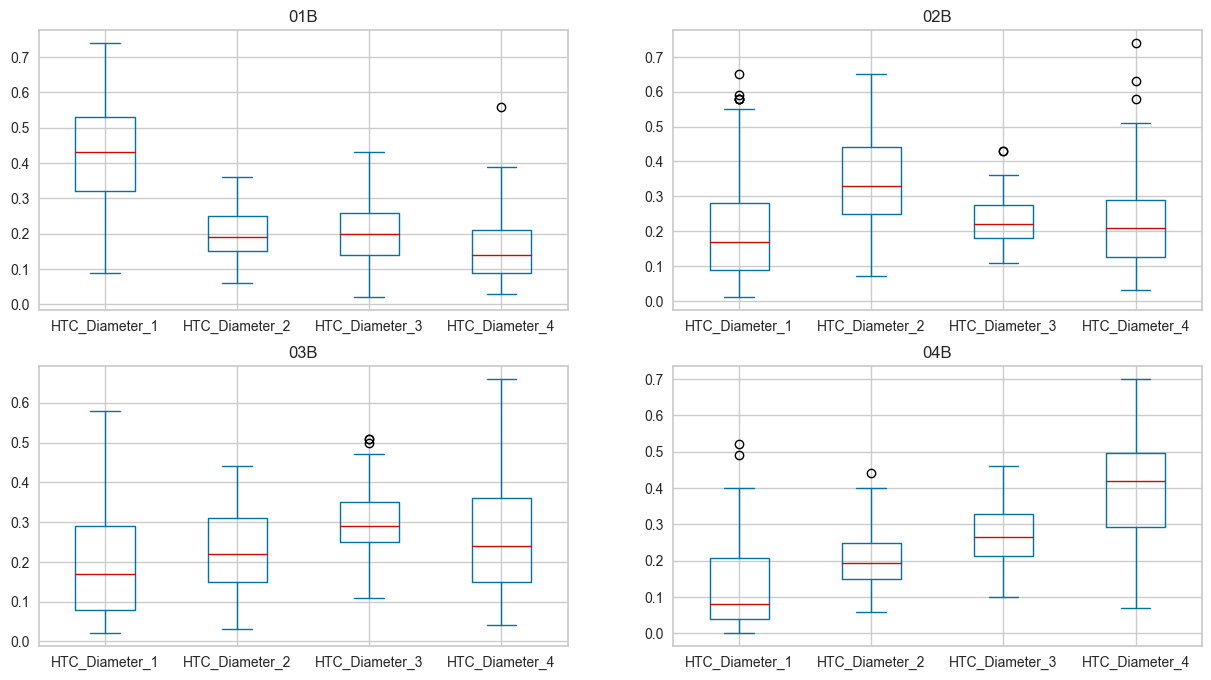

In [87]:
fig, ax = plt.subplots(2,2, figsize=(15,8))
df_trg_diameter.loc[df_trg_diameter['difficulty'] == '01B'].plot(kind='box', ax=ax[0][0], title='01B')
df_trg_diameter.loc[df_trg_diameter['difficulty'] == '02B'].plot(kind='box', ax=ax[0][1], title='02B')
df_trg_diameter.loc[df_trg_diameter['difficulty'] == '03B'].plot(kind='box', ax=ax[1][0], title='03B')
df_trg_diameter.loc[df_trg_diameter['difficulty'] == '04B'].plot(kind='box', ax=ax[1][1], title='04B')
fig.show()

### Boxplot of gaze direction feature in training set
This shows clearly that the gaze direction feature predicts a difficulty level strongly as the distribution of probabilities shows a clear preference for the correct difficulty level.

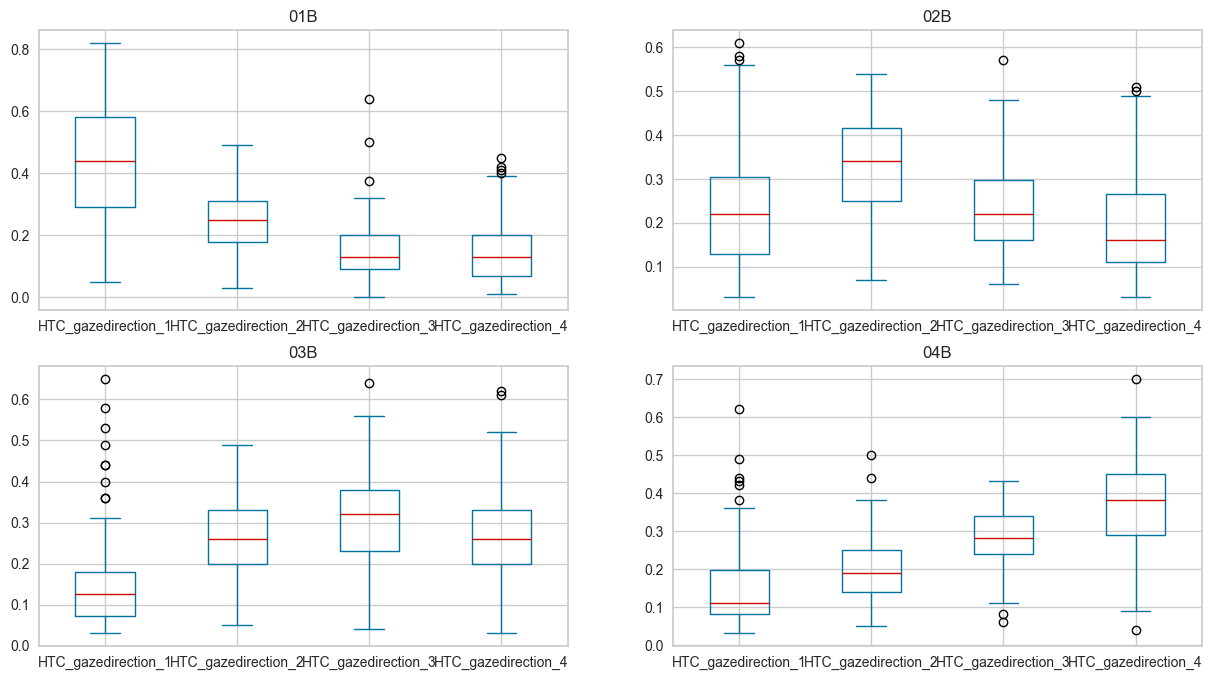

In [53]:
fig, ax = plt.subplots(2,2, figsize=(15,8))
df_trg_gazedir.loc[df_trg_gazedir['difficulty'] == '01B'].plot(kind='box', ax=ax[0][0], title='01B')
df_trg_gazedir.loc[df_trg_gazedir['difficulty'] == '02B'].plot(kind='box', ax=ax[0][1], title='02B')
df_trg_gazedir.loc[df_trg_gazedir['difficulty'] == '03B'].plot(kind='box', ax=ax[1][0], title='03B')
df_trg_gazedir.loc[df_trg_gazedir['difficulty'] == '04B'].plot(kind='box', ax=ax[1][1], title='04B')
fig.show()

### Boxplot of respiration feature in training set
This shows that the respiration feature has weaker predictive power as the distribution of probabilities does not show a clear preference for the correct difficulty level except for difficulty level 1.

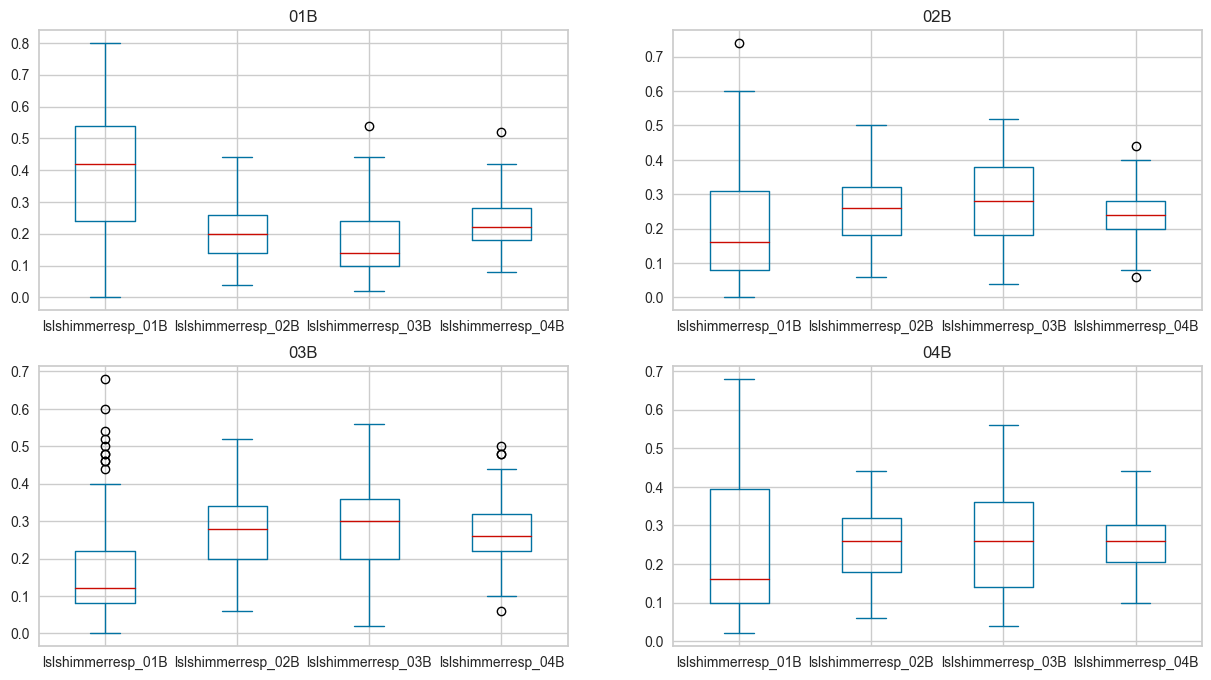

In [54]:
fig, ax = plt.subplots(2,2, figsize=(15,8))
df_trg_resp.loc[df_trg_resp['difficulty'] == '01B'].plot(kind='box', ax=ax[0][0], title='01B')
df_trg_resp.loc[df_trg_resp['difficulty'] == '02B'].plot(kind='box', ax=ax[0][1], title='02B')
df_trg_resp.loc[df_trg_resp['difficulty'] == '03B'].plot(kind='box', ax=ax[1][0], title='03B')
df_trg_resp.loc[df_trg_resp['difficulty'] == '04B'].plot(kind='box', ax=ax[1][1], title='04B')
fig.show()

### Boxplot of ECG feature in training set
This shows that the ECG feature has weaker predictive power as the distribution of probabilities does not show a clear preference for the correct difficulty level except for difficulty level 1.

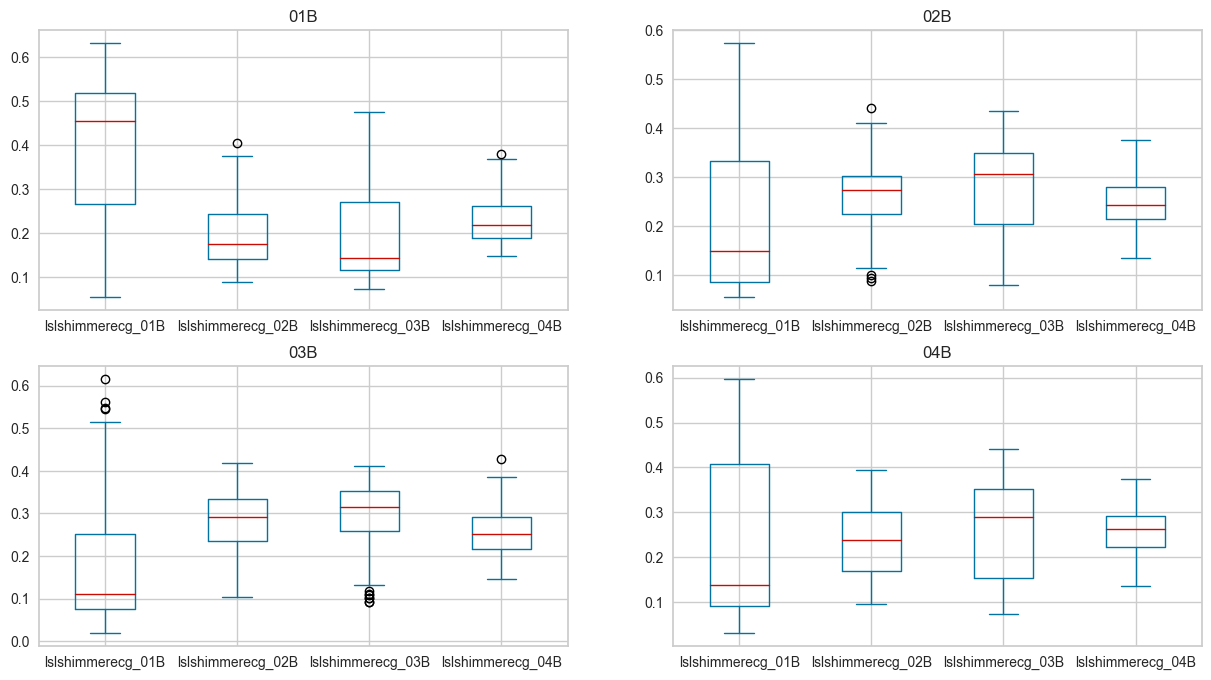

In [55]:
fig, ax = plt.subplots(2,2, figsize=(15,8))
df_trg_ecg.loc[df_trg_ecg['difficulty'] == '01B'].plot(kind='box', ax=ax[0][0], title='01B')
df_trg_ecg.loc[df_trg_ecg['difficulty'] == '02B'].plot(kind='box', ax=ax[0][1], title='02B')
df_trg_ecg.loc[df_trg_ecg['difficulty'] == '03B'].plot(kind='box', ax=ax[1][0], title='03B')
df_trg_ecg.loc[df_trg_ecg['difficulty'] == '04B'].plot(kind='box', ax=ax[1][1], title='04B')
fig.show()

### Boxplot of gaze origin feature in training set
This shows that the gaze origin feature has weaker predictive power as the distribution of probabilities does not show a clear preference for the correct difficulty level except for difficulty level 1.

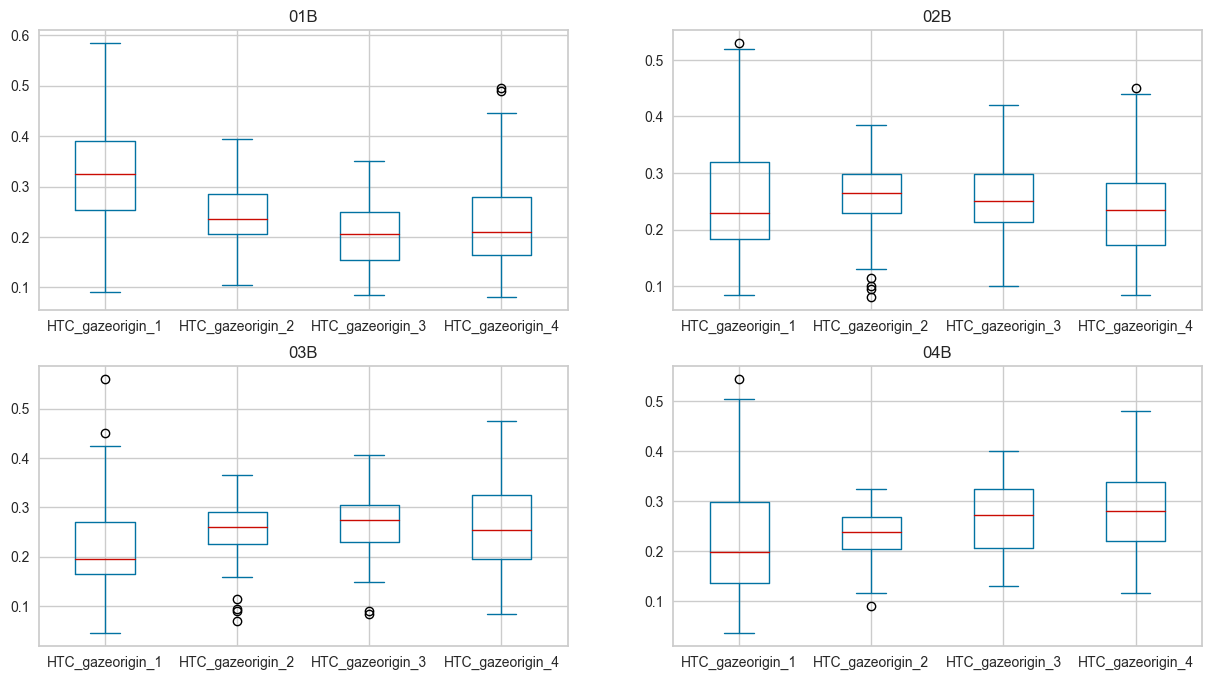

In [56]:
fig, ax = plt.subplots(2,2, figsize=(15,8))
df_trg_gazeorigin.loc[df_trg_gazeorigin['difficulty'] == '01B'].plot(kind='box', ax=ax[0][0], title='01B')
df_trg_gazeorigin.loc[df_trg_gazeorigin['difficulty'] == '02B'].plot(kind='box', ax=ax[0][1], title='02B')
df_trg_gazeorigin.loc[df_trg_gazeorigin['difficulty'] == '03B'].plot(kind='box', ax=ax[1][0], title='03B')
df_trg_gazeorigin.loc[df_trg_gazeorigin['difficulty'] == '04B'].plot(kind='box', ax=ax[1][1], title='04B')
fig.show()

## Try different combinations for final model

### Pupil Diameter only

In [91]:
diameter_setup = setup(df_trg_diameter, target = 'difficulty', ignore_features='subject', fold_strategy='groupkfold', fold_groups='subject')
best_diameter = compare_models(sort='F1', n_select=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.6480,0.8300,0.6480,0.6662,0.6412,0.5259,0.5357,0.1700
lightgbm,Light Gradient Boosting Machine,0.6282,0.8050,0.6282,0.6631,0.6275,0.5005,0.5094,0.0620
et,Extra Trees Classifier,0.6321,0.8533,0.6321,0.6470,0.6253,0.5040,0.5125,0.1680
gbc,Gradient Boosting Classifier,0.6159,0.8162,0.6159,0.6411,0.6141,0.4847,0.4918,0.2890
dt,Decision Tree Classifier,0.5948,0.7323,0.5948,0.6185,0.5932,0.4566,0.4637,0.0250
lda,Linear Discriminant Analysis,0.5347,0.7868,0.5347,0.5505,0.5256,0.3740,0.3828,0.0260
lr,Logistic Regression,0.5433,0.7760,0.5433,0.5538,0.5200,0.3882,0.4034,0.0330
nb,Naive Bayes,0.5346,0.7801,0.5346,0.5310,0.5192,0.3757,0.3842,0.0250
qda,Quadratic Discriminant Analysis,0.5212,0.7825,0.5212,0.5516,0.5116,0.3568,0.3703,0.0250
ridge,Ridge Classifier,0.5383,0.0000,0.5383,0.5442,0.5091,0.3795,0.3965,0.0220


### Gaze Direction only

In [93]:
gazedir_setup = setup(df_trg_gazedir, target = 'difficulty', ignore_features='subject', fold_strategy='groupkfold', fold_groups='subject')
best_gazedir = compare_models(sort='F1', n_select=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.5799,0.8006,0.5799,0.5981,0.5733,0.4413,0.4505,0.0320
lr,Logistic Regression,0.5698,0.8049,0.5698,0.6042,0.5661,0.4294,0.4390,0.0340
lda,Linear Discriminant Analysis,0.5567,0.8030,0.5567,0.6018,0.5546,0.4118,0.4225,0.0270
ridge,Ridge Classifier,0.5570,0.0000,0.5570,0.5997,0.5475,0.4120,0.4244,0.0250
knn,K Neighbors Classifier,0.5075,0.7481,0.5075,0.5241,0.5023,0.3427,0.3478,0.0360
rf,Random Forest Classifier,0.5030,0.7505,0.5030,0.5212,0.4951,0.3393,0.3464,0.1780
lightgbm,Light Gradient Boosting Machine,0.4917,0.7519,0.4917,0.5146,0.4813,0.3228,0.3313,0.0640
svm,SVM - Linear Kernel,0.5028,0.0000,0.5028,0.5737,0.4787,0.3464,0.3746,0.0310
et,Extra Trees Classifier,0.4844,0.7455,0.4844,0.5058,0.4778,0.3152,0.3211,0.1900
gbc,Gradient Boosting Classifier,0.4672,0.7377,0.4672,0.5054,0.4636,0.2948,0.3030,0.3230


### Pupil Diameter + Gaze Direction

In [94]:
df_trg_diameter_gazedir = df_trg_full.copy()
df_trg_diameter_gazedir = df_trg_diameter_gazedir[['subject', 'difficulty', 'HTC_Diameter_1', 'HTC_Diameter_2', 'HTC_Diameter_3', 'HTC_Diameter_4', 'HTC_gazedirection_1', 'HTC_gazedirection_2', 'HTC_gazedirection_3', 'HTC_gazedirection_4']]

diameter_gazedir_setup = setup(df_trg_diameter_gazedir, target = 'difficulty', ignore_features='subject', fold_strategy='groupkfold', fold_groups='subject')
best_diameter_gazedir = compare_models(sort='F1', n_select=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.6556,0.8437,0.6556,0.6960,0.6485,0.5380,0.5526,0.1910
nb,Naive Bayes,0.6473,0.8406,0.6473,0.6993,0.6400,0.5245,0.5416,0.0290
gbc,Gradient Boosting Classifier,0.6387,0.8288,0.6387,0.6774,0.6352,0.5131,0.5233,0.3180
rf,Random Forest Classifier,0.6387,0.8362,0.6387,0.6861,0.6331,0.5154,0.5304,0.1930
lightgbm,Light Gradient Boosting Machine,0.6352,0.8303,0.6352,0.6869,0.6325,0.5102,0.5228,0.0670
lr,Logistic Regression,0.6361,0.8367,0.6361,0.6828,0.6282,0.5099,0.5251,0.0280
lda,Linear Discriminant Analysis,0.6315,0.8333,0.6315,0.6721,0.6262,0.5034,0.5161,0.0260
ridge,Ridge Classifier,0.6255,0.0000,0.6255,0.6682,0.6166,0.4960,0.5108,0.0250
qda,Quadratic Discriminant Analysis,0.5895,0.7943,0.5895,0.6300,0.5854,0.4464,0.4600,0.0260
svm,SVM - Linear Kernel,0.5955,0.0000,0.5955,0.6969,0.5797,0.4536,0.4824,0.0310


### Pupil Diameter + Gaze Direction + Respiration

In [95]:
df_trg_diameter_gazedir_resp = df_trg_full.copy()
df_trg_diameter_gazedir_resp = df_trg_diameter_gazedir_resp[['subject', 'difficulty', 'HTC_Diameter_1', 'HTC_Diameter_2', 'HTC_Diameter_3', 'HTC_Diameter_4', 'HTC_gazedirection_1', 'HTC_gazedirection_2', 'HTC_gazedirection_3', 'HTC_gazedirection_4', 'lslshimmerresp_01B', 'lslshimmerresp_02B', 'lslshimmerresp_03B', 'lslshimmerresp_04B']]

diameter_gazedir_resp_setup = setup(df_trg_diameter_gazedir_resp, target = 'difficulty', ignore_features='subject', fold_strategy='groupkfold', fold_groups='subject')
best_diameter_gazedir_resp = compare_models(sort='F1', n_select=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6482,0.8153,0.6482,0.6759,0.6401,0.5279,0.5410,0.0370
rf,Random Forest Classifier,0.6456,0.8189,0.6456,0.6674,0.6382,0.5253,0.5350,0.1740
ridge,Ridge Classifier,0.6499,0.0000,0.6499,0.6658,0.6360,0.5306,0.5432,0.0210
nb,Naive Bayes,0.6407,0.8320,0.6407,0.6562,0.6320,0.5182,0.5300,0.0280
lda,Linear Discriminant Analysis,0.6369,0.8129,0.6369,0.6551,0.6253,0.5108,0.5220,0.0290
gbc,Gradient Boosting Classifier,0.6228,0.7894,0.6228,0.6521,0.6142,0.4938,0.5031,0.3260
et,Extra Trees Classifier,0.6178,0.8145,0.6178,0.6429,0.6101,0.4870,0.4972,0.1910
lightgbm,Light Gradient Boosting Machine,0.6086,0.7918,0.6086,0.6372,0.6022,0.4760,0.4842,0.0810
knn,K Neighbors Classifier,0.5753,0.7669,0.5753,0.5948,0.5697,0.4312,0.4386,0.0390
svm,SVM - Linear Kernel,0.5790,0.0000,0.5790,0.6090,0.5562,0.4295,0.4485,0.0260


### Pupil Diameter + Gaze Direction + Respiration + ECG

In [102]:
df_trg_diameter_gazedir_resp_ecg = df_trg_full.copy()
df_trg_diameter_gazedir_resp_ecg = df_trg_diameter_gazedir_resp_ecg[['subject', 'difficulty', 'HTC_Diameter_1', 'HTC_Diameter_2', 'HTC_Diameter_3', 'HTC_Diameter_4', 'HTC_gazedirection_1', 'HTC_gazedirection_2', 'HTC_gazedirection_3', 'HTC_gazedirection_4', 'lslshimmerresp_01B', 'lslshimmerresp_02B', 'lslshimmerresp_03B', 'lslshimmerresp_04B', 'lslshimmerecg_01B', 'lslshimmerecg_02B', 'lslshimmerecg_03B', 'lslshimmerecg_04B']]

diameter_gazedir_resp_ecg_setup = setup(df_trg_diameter_gazedir_resp_ecg, target = 'difficulty', ignore_features='subject', fold_strategy='groupkfold', fold_groups='subject')
best_diameter_gazedir_resp_ecg = compare_models(sort='F1', n_select=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6690,0.8532,0.6690,0.7269,0.6620,0.5592,0.5762,0.0340
lda,Linear Discriminant Analysis,0.6534,0.8629,0.6534,0.7278,0.6471,0.5388,0.5604,0.0240
ridge,Ridge Classifier,0.6420,0.0000,0.6420,0.6994,0.6313,0.5223,0.5409,0.0230
rf,Random Forest Classifier,0.6344,0.8427,0.6344,0.6841,0.6286,0.5126,0.5273,0.1720
gbc,Gradient Boosting Classifier,0.6255,0.8120,0.6255,0.6736,0.6199,0.5000,0.5153,0.3220
nb,Naive Bayes,0.6254,0.8531,0.6254,0.6783,0.6152,0.5002,0.5151,0.0260
et,Extra Trees Classifier,0.6175,0.8348,0.6175,0.6640,0.6106,0.4916,0.5052,0.1580
knn,K Neighbors Classifier,0.6133,0.7909,0.6133,0.6591,0.6078,0.4831,0.4971,0.0290
lightgbm,Light Gradient Boosting Machine,0.6095,0.8282,0.6095,0.6741,0.6053,0.4811,0.4947,0.0650
svm,SVM - Linear Kernel,0.6117,0.0000,0.6117,0.7259,0.5902,0.4782,0.5171,0.0240


### Pupil Diameter + Gaze Direction + Respiration + ECG + Gaze Origin

In [98]:
df_trg_diameter_gazedir_resp_ecg_gazeorgin = df_trg_full.copy()
df_trg_diameter_gazedir_resp_ecg_gazeorgin = df_trg_diameter_gazedir_resp_ecg_gazeorgin[['subject', 'difficulty', 'HTC_Diameter_1', 'HTC_Diameter_2', 'HTC_Diameter_3', 'HTC_Diameter_4', 'HTC_gazedirection_1', 'HTC_gazedirection_2', 'HTC_gazedirection_3', 'HTC_gazedirection_4', 'lslshimmerresp_01B', 'lslshimmerresp_02B', 'lslshimmerresp_03B', 'lslshimmerresp_04B', 'lslshimmerecg_01B', 'lslshimmerecg_02B', 'lslshimmerecg_03B', 'lslshimmerecg_04B', 'HTC_gazeorigin_1', 'HTC_gazeorigin_2', 'HTC_gazeorigin_3', 'HTC_gazeorigin_4']]

diameter_gazedir_resp_ecg_gazeorgin_setup = setup(df_trg_diameter_gazedir_resp_ecg_gazeorgin, target = 'difficulty', ignore_features='subject', fold_strategy='groupkfold', fold_groups='subject')
best_diameter_gazedir_resp_ecg_gazeorgin = compare_models(sort='F1', n_select=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.6594,0.0000,0.6594,0.6901,0.6472,0.5436,0.5620,0.0290
lr,Logistic Regression,0.6528,0.8531,0.6528,0.6852,0.6447,0.5337,0.5486,0.0370
lda,Linear Discriminant Analysis,0.6359,0.8557,0.6359,0.6705,0.6277,0.5126,0.5271,0.0280
gbc,Gradient Boosting Classifier,0.5979,0.8032,0.5979,0.6391,0.5931,0.4615,0.4784,0.3480
nb,Naive Bayes,0.6011,0.8416,0.6011,0.6430,0.5926,0.4633,0.4816,0.0270
rf,Random Forest Classifier,0.5961,0.8184,0.5961,0.6325,0.5899,0.4583,0.4800,0.1850
svm,SVM - Linear Kernel,0.6133,0.0000,0.6133,0.6792,0.5852,0.4807,0.5207,0.0270
et,Extra Trees Classifier,0.5895,0.8192,0.5895,0.6233,0.5770,0.4490,0.4659,0.1640
lightgbm,Light Gradient Boosting Machine,0.5830,0.8186,0.5830,0.6276,0.5746,0.4405,0.4605,0.0640
knn,K Neighbors Classifier,0.5396,0.7498,0.5396,0.5670,0.5325,0.3824,0.3945,0.0310


### Pupil Diameter + Gaze Direction + Respiration + ECG + Torsoacc

In [99]:
df_trg_diameter_gazedir_resp_ecg_torsoacc = df_trg_full.copy()
df_trg_diameter_gazedir_resp_ecg_torsoacc = df_trg_diameter_gazedir_resp_ecg_torsoacc[['subject', 'difficulty', 'HTC_Diameter_1', 'HTC_Diameter_2', 'HTC_Diameter_3', 'HTC_Diameter_4', 'HTC_gazedirection_1', 'HTC_gazedirection_2', 'HTC_gazedirection_3', 'HTC_gazedirection_4', 'lslshimmerresp_01B', 'lslshimmerresp_02B', 'lslshimmerresp_03B', 'lslshimmerresp_04B', 'lslshimmerecg_01B', 'lslshimmerecg_02B', 'lslshimmerecg_03B', 'lslshimmerecg_04B', 'lslshimmertorsoacc_01B', 'lslshimmertorsoacc_02B','lslshimmertorsoacc_03B', 'lslshimmertorsoacc_04B']]

diameter_gazedir_resp_ecg_torsoacc_setup = setup(df_trg_diameter_gazedir_resp_ecg_torsoacc, target = 'difficulty', ignore_features='subject', fold_strategy='groupkfold', fold_groups='subject')
best_diameter_gazedir_resp_ecg_torsoacc = compare_models(sort='F1', n_select=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.6749,0.8351,0.6749,0.7125,0.6702,0.5645,0.5788,0.1600
lr,Logistic Regression,0.6708,0.8463,0.6708,0.7078,0.6607,0.5578,0.5713,0.0320
rf,Random Forest Classifier,0.6456,0.8148,0.6456,0.6930,0.6400,0.5244,0.5379,0.1990
lda,Linear Discriminant Analysis,0.6404,0.8340,0.6404,0.6807,0.6277,0.5172,0.5345,0.0290
ridge,Ridge Classifier,0.6320,0.0000,0.6320,0.6552,0.6172,0.5047,0.5215,0.0260
gbc,Gradient Boosting Classifier,0.6102,0.8056,0.6102,0.6238,0.6037,0.4763,0.4834,0.3280
knn,K Neighbors Classifier,0.6070,0.7811,0.6070,0.6471,0.5987,0.4716,0.4816,0.0300
lightgbm,Light Gradient Boosting Machine,0.6034,0.8127,0.6034,0.6226,0.5917,0.4693,0.4806,0.0710
nb,Naive Bayes,0.5910,0.8326,0.5910,0.6330,0.5797,0.4502,0.4650,0.0300
svm,SVM - Linear Kernel,0.5595,0.0000,0.5595,0.6391,0.5370,0.4102,0.4469,0.0280


### Pupil Diameter + Gaze Direction + Respiration + ECG + Eyeopeness

In [100]:
df_trg_diameter_gazedir_resp_ecg_eyeopen = df_trg_full.copy()
df_trg_diameter_gazedir_resp_ecg_eyeopen = df_trg_diameter_gazedir_resp_ecg_eyeopen[['subject', 'difficulty', 'HTC_Diameter_1', 'HTC_Diameter_2', 'HTC_Diameter_3', 'HTC_Diameter_4', 'HTC_gazedirection_1', 'HTC_gazedirection_2', 'HTC_gazedirection_3', 'HTC_gazedirection_4', 'lslshimmerresp_01B', 'lslshimmerresp_02B', 'lslshimmerresp_03B', 'lslshimmerresp_04B', 'lslshimmerecg_01B', 'lslshimmerecg_02B', 'lslshimmerecg_03B', 'lslshimmerecg_04B', 'HTC_eyeopenness_1', 'HTC_eyeopenness_2', 'HTC_eyeopenness_3', 'HTC_eyeopenness_4']]

diameter_gazedir_resp_ecg_eyeopen_setup = setup(df_trg_diameter_gazedir_resp_ecg_eyeopen, target = 'difficulty', ignore_features='subject', fold_strategy='groupkfold', fold_groups='subject')
best_diameter_gazedir_resp_ecg_eyeopen = compare_models(sort='F1', n_select=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6646,0.8352,0.6646,0.7171,0.6643,0.5529,0.5692,0.0370
lda,Linear Discriminant Analysis,0.6449,0.8237,0.6449,0.6911,0.6449,0.5257,0.5390,0.0300
ridge,Ridge Classifier,0.6478,0.0000,0.6478,0.6933,0.6431,0.5312,0.5467,0.0260
et,Extra Trees Classifier,0.6382,0.8339,0.6382,0.6901,0.6361,0.5197,0.5385,0.1830
rf,Random Forest Classifier,0.6275,0.8285,0.6275,0.6722,0.6241,0.5044,0.5214,0.1920
nb,Naive Bayes,0.6136,0.8257,0.6136,0.6623,0.6060,0.4848,0.5006,0.0300
gbc,Gradient Boosting Classifier,0.6046,0.8066,0.6046,0.6512,0.6020,0.4744,0.4886,0.3620
lightgbm,Light Gradient Boosting Machine,0.6046,0.8000,0.6046,0.6713,0.5955,0.4760,0.4965,0.0730
knn,K Neighbors Classifier,0.5783,0.7831,0.5783,0.5967,0.5688,0.4386,0.4510,0.0280
ada,Ada Boost Classifier,0.5328,0.7448,0.5328,0.5791,0.5314,0.3754,0.3871,0.0950


# Train final model with Pupil Diameter + Gaze Direction + Respiration + ECG features
These features make the most sense from a physiological perspective and is supported by the validation of the models above.

In [104]:
# Set up df
df_trg_diameter_gazedir_resp_ecg = df_trg_full.copy()
df_trg_diameter_gazedir_resp_ecg = df_trg_diameter_gazedir_resp_ecg[['subject', 'difficulty', 'HTC_Diameter_1', 'HTC_Diameter_2', 'HTC_Diameter_3', 'HTC_Diameter_4', 'HTC_gazedirection_1', 'HTC_gazedirection_2', 'HTC_gazedirection_3', 'HTC_gazedirection_4', 'lslshimmerresp_01B', 'lslshimmerresp_02B', 'lslshimmerresp_03B', 'lslshimmerresp_04B', 'lslshimmerecg_01B', 'lslshimmerecg_02B', 'lslshimmerecg_03B', 'lslshimmerecg_04B']]

# Train model
diameter_gazedir_resp_ecg_setup = setup(df_trg_diameter_gazedir_resp_ecg, target = 'difficulty', ignore_features='subject', fold_strategy='groupkfold', fold_groups='subject')
best_diameter_gazedir_resp_ecg = compare_models(sort='F1', n_select=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6570,0.8294,0.6570,0.7037,0.6546,0.5425,0.5542,0.0330
et,Extra Trees Classifier,0.6344,0.8118,0.6344,0.6676,0.6300,0.5105,0.5216,0.1640
gbc,Gradient Boosting Classifier,0.6222,0.7972,0.6222,0.6649,0.6208,0.4956,0.5063,0.3250
lda,Linear Discriminant Analysis,0.6172,0.8211,0.6172,0.6630,0.6140,0.4882,0.4999,0.0240
nb,Naive Bayes,0.6096,0.8234,0.6096,0.6577,0.6115,0.4774,0.4883,0.0280
ridge,Ridge Classifier,0.6168,0.0000,0.6168,0.6690,0.6091,0.4898,0.5030,0.0290
rf,Random Forest Classifier,0.6109,0.8133,0.6109,0.6508,0.6091,0.4813,0.4915,0.1720
lightgbm,Light Gradient Boosting Machine,0.5992,0.7868,0.5992,0.6370,0.5914,0.4654,0.4759,0.0640
knn,K Neighbors Classifier,0.5924,0.7839,0.5924,0.6346,0.5876,0.4560,0.4672,0.0280
svm,SVM - Linear Kernel,0.5511,0.0000,0.5511,0.5861,0.5189,0.3967,0.4263,0.0280


In [105]:
# save model
with open(os.path.join(model_dir, 'final_ensemble_model.pkl'), 'wb') as f:
    pickle.dump(best_diameter_gazedir_resp_ecg[0], f)

best_diameter_gazedir_resp_ecg[0] 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=796, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Generate predictions on eval data

In [114]:
df_eval_full

,subject,run,date,lslshimmerecg_01B,lslshimmerecg_02B,lslshimmerecg_03B,lslshimmerecg_04B,lslshimmerresp_01B,lslshimmerresp_02B,lslshimmerresp_03B,...,HTC_gazeorigin_3,HTC_gazeorigin_4,HTC_Diameter_1,HTC_Diameter_2,HTC_Diameter_3,HTC_Diameter_4,HTC_pupilposi_1,HTC_pupilposi_2,HTC_pupilposi_3,HTC_pupilposition_4
0,cp040,21,20220305,0.436,0.160,0.132,0.272,0.54,0.24,0.02,...,0.335,0.235,0.050000,0.17,0.240000,0.54,0.189167,0.16,0.430833,0.22
1,cp040,22,20220305,0.436,0.160,0.132,0.272,0.36,0.20,0.10,...,0.310,0.245,0.100000,0.18,0.300000,0.42,0.257500,0.26,0.272500,0.21
2,cp040,23,20220305,0.436,0.160,0.132,0.272,0.50,0.10,0.12,...,0.295,0.185,0.103333,0.23,0.446667,0.22,0.209167,0.32,0.300833,0.17
3,cp040,24,20220305,0.436,0.160,0.132,0.272,0.50,0.20,0.12,...,0.295,0.180,0.180000,0.23,0.390000,0.20,0.290000,0.17,0.280000,0.26
4,cp040,25,20220305,0.518,0.144,0.086,0.252,0.52,0.12,0.10,...,0.310,0.210,0.030000,0.28,0.230000,0.46,0.259167,0.22,0.370833,0.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,cp049,28,20230105,0.544,0.134,0.108,0.214,0.52,0.18,0.12,...,0.315,0.290,0.080000,0.23,0.440000,0.25,0.305333,0.12,0.434667,0.14
92,cp049,29,20230105,0.394,0.122,0.152,0.332,0.38,0.18,0.16,...,0.300,0.330,0.110000,0.35,0.300000,0.24,0.323000,0.13,0.417000,0.13
93,cp049,30,20230105,0.518,0.138,0.108,0.236,0.58,0.22,0.08,...,0.275,0.305,0.220000,0.31,0.320000,0.15,0.205000,0.19,0.385000,0.22
94,cp049,31,20230105,0.458,0.140,0.138,0.264,0.50,0.06,0.12,...,0.285,0.295,0.170000,0.32,0.280000,0.23,0.256333,0.15,0.403667,0.19


In [117]:
df_eval_selected = df_eval_full.copy()
df_eval_selected = df_eval_selected[['HTC_Diameter_1', 'HTC_Diameter_2', 'HTC_Diameter_3', 'HTC_Diameter_4', 'HTC_gazedirection_1', 'HTC_gazedirection_2', 'HTC_gazedirection_3', 'HTC_gazedirection_4', 'lslshimmerresp_01B', 'lslshimmerresp_02B', 'lslshimmerresp_03B', 'lslshimmerresp_04B', 'lslshimmerecg_01B', 'lslshimmerecg_02B', 'lslshimmerecg_03B', 'lslshimmerecg_04B']]

In [121]:
# Load model
with open(os.path.join(model_dir, 'final_ensemble_model.pkl'), 'rb') as f:
    clf = pickle.load(f)

# Predict
y_pred_eval = clf.predict_proba(df_eval_selected)
y_pred = clf.predict(df_eval_selected)

In [128]:
y_pred_eval = pd.DataFrame(y_pred_eval, columns=['DL1','DL2','DL3','DL4'])
y_pred = pd.DataFrame(y_pred, columns=['Predicted DL'])
y_pred['Predicted DL'] = y_pred['Predicted DL'] + 1
final_run_info = df_eval_full[['subject', 'date', 'run']]
final_run_info.columns = ['Subject', 'Date', 'Run']
final_eval_predictions = pd.concat([final_run_info, y_pred, y_pred_eval], axis=1)
final_eval_predictions.to_csv(os.path.join(main_dir, 'RSAF+_TASK1_predictions.csv'), index=False)
final_eval_predictions

,Subject,Date,Run,Predicted DL,DL1,DL2,DL3,DL4
0,cp040,20220305,21,4,0.057917,0.093897,0.146153,0.702033
1,cp040,20220305,22,4,0.080137,0.141244,0.256208,0.522410
2,cp040,20220305,23,1,0.271782,0.270754,0.246714,0.210750
3,cp040,20220305,24,1,0.689467,0.135288,0.067212,0.108033
4,cp040,20220305,25,4,0.086954,0.278452,0.183343,0.451251
...,...,...,...,...,...,...,...,...
91,cp049,20230105,28,4,0.245599,0.216527,0.221812,0.316062
92,cp049,20230105,29,2,0.124350,0.361985,0.269997,0.243669
93,cp049,20230105,30,1,0.445435,0.319403,0.116948,0.118213
94,cp049,20230105,31,1,0.435931,0.313927,0.102318,0.147824
